# Prédicition de la variable des émissions de gaz à effet de serre des bâtiments de SEATTLE

In [1]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import scipy
import scipy.stats
from pathlib import Path
import timeit
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import FETCH_LOAD_DATAS
from TUNING_SUPERVISED_MODELS import *

##### Paramètres généraux d'affichage et fonction de sauvegarde des visualisations

In [2]:
SEED = 49

In [3]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)

plt.rcParams['figure.figsize'] = [10, 8]

In [4]:
IMAGES_PATH = Path() / "img" / "prediction_co2"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"prediction_co2 - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

##### Chargements des données et initialisation des variables utiles

In [5]:
data = pd.read_csv("datasets/df_EDA.csv")
df = data.copy()

Nous allons dans un premier temps chercher à optimiser un modèle nous permettant d'obtenir les meilleures performances possibles pour la prédiction de notre valeur cible de co2mation d'énergie, sans la variable **ENRGYSTARScore**, puis nous verrons en la rajoutant à notre jeu de données si elle permet d'atteindre de meilleurs résulats.

In [6]:
df.head()

LargestPropertyUseType Neighborhood PrimaryPropertyType  \
0                  Hotel     DOWNTOWN               Hotel   
1                  Hotel     DOWNTOWN               Hotel   
2                  Hotel     DOWNTOWN               Hotel   
3                  Hotel     DOWNTOWN               Hotel   
4                  Hotel     DOWNTOWN               Hotel   

  SecondLargestPropertyUseType ThirdLargestPropertyUseType  \
0                         None                        None   
1                      Parking                  Restaurant   
2                         None                        None   
3                         None                        None   
4                      Parking               Swimming Pool   

   LargestPropertyUseTypeGFA  PropertyGFATotal  \
0                    88434.0             88434   
1                    83880.0            103566   
2                   756493.0            956110   
3                    61320.0             61320   
4                   123445.0            175580   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   

   ENERGYSTARScore  Latitude  Longitude  NumberofBuildings  NumberofFloors  \
0             60.0  47.61220 -122.33799                1.0              12   
1             61.0  47.61317 -122.33393                1.0              11   
2             43.0  47.61393 -122.33810                1.0              41   
3             56.0  47.61412 -122.33664                1.0              10   
4             75.0  47.61375 -122.34047                1.0              18   

   PropertyGFABuilding(s)  PropertyGFAParking  YearBuilt  SiteEnergyUse(kBtu)  \
0                   88434                   0       1927            7226362.5   
1                   88502               15064       1996            8387933.0   
2                  759392              196718       1969           72587024.0   
3                   61320                   0       1926            6794584.0   
4                  113580               62000       1980           14172606.0   

   TotalGHGEmissions  
0             249.98  
1             295.86  
2            2089.28  
3             286.43  
4             505.01

In [7]:
co2 = 'TotalGHGEmissions'

cat_features = ['Neighborhood', 'PrimaryPropertyType',
                'LargestPropertyUseType',
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

num_features = ['LargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'NumberofBuildings', 
                     'NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
                     'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt']

log_features = ['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 
                'ThirdLargestPropertyUseTypeGFA']

std_features = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
                'PropertyGFAParking', 'YearBuilt']

In [8]:
df = df[num_features+cat_features+[co2]]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=co2),df[co2], test_size=0.2, random_state=SEED)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
cat_features_ind = [X_train.columns.get_loc(ft) for ft in cat_features]
numerical_features_ind = [X_train.columns.get_loc(ft) for ft in num_features]
log_features_ind = [X_train.columns.get_loc(ft) for ft in log_features]
std_features_ind = [X_train.columns.get_loc(ft) for ft in std_features]

# Première estimation de performance

### Métriques de performance

Pour notre problématiques, les métriques de performances auxquelles nous allons être attentifs sont la **RMSE**, la **RMSLE** et la **MAE** plus que le score **R²**.

En effet ce dernier peut être interprété comme la proportion de variance dans le jeu de données que notre modèle entraîné est capable d'expliquer, et dépend donc beaucoup du jeu de données. Nous lui préférerons les mesures de performances neutres citées ci-avant, ainsi que le **score R² ajusté** qui permet de mieux quantifier la robustesse de notre modèle (la valeur de la mesure **R² ajusté** est toujours inférieure ou égale à la valeur de **R²**).

### Utilisation de la librairie PyCaret pour nos estimations de performance

Nous allons lancé une batterie de modèles standards avec leurs paramètres par défaut sur notre jeu de données brut afin d'avoir une **performance de base** à laquelle nous allons comparer la performance du modèle dont nous ajusterons les hyperparamètres après avoir réalisé un travail spécifique sur les variables (**feature engineering**).

Pour cela, nous utilisons la librairie **PyCaret** (https://github.com/pycaret/pycaret) qui est la version Python de la librairie **Caret** pour **R** (**C**lassification **A**nd **RE**gression **T**raining) pour se faire une idée des modèles qui sont pertinents pour répondre à notre problématique de régression.

Voici les caractéristiques des entraînements de modèles réalisés par **PyCaret**:

   1. **OneHotEncoding** sur les variables catégorielles
   2. Les variables numériques sont normalisées (les **SVM** et **KNN** sont sensibles aux différences d'échelle)
   3. Aucune sélection de variable ni élimination de la multicollinéarité entre elles
   4. Les résultats sont une moyenne suite à une validation croisée simple à 10 passes (K-Fold)

In [11]:
df_train = X_train.copy()
df_train['TARGET'] = y_train

In [12]:
s = setup(df_train, target = 'TARGET', normalize=True, session_id=SEED, silent=True)

best_models = compare_models(sort='RMSE', exclude=['lar', 'llar'])

# Traitement des valeurs aberrantes

Nous choisissons d'utiliser le critère de l'**inter-quartile** pour traiter les valeurs aberrantes, car nous n'avons pas besoins de faire d'hypothèses sur la distribution des variables.

Nous allons pour cela créer une fonction qui fera partie du processus global de pré-traitement des données avant l'évaluation de modèles pouvant potentiellement répondre à notre problématique, et nous pourrons ainsi observer l'impact de la présence de cette étape de traitement sur les performances des modèles (d'autant plus que cette étape nous prive d'un nombre important d'observations, **près de 60%**, voir ci-après).

In [13]:
def remove_outliers_IR(data):
    df = data.copy()
    for col in data.select_dtypes(include=np.number).columns:
        Q3 = df.describe()[col]['75%']
        Q1 = df.describe()[col]['25%']
        IR = Q3 - Q1
        df.drop(index=df[df[col]>Q3+1.5*IR].index, inplace=True)
        df.drop(index=df[df[col]<Q1-1.5*IR].index, inplace=True)
    return df

In [14]:
df_train.shape[0], remove_outliers_IR(df_train).shape[0], f"{(df_train.shape[0]-remove_outliers_IR(df_train).shape[0])/df_train.shape[0]}%"

(1249, 524, '0.5804643714971978%')

# Évaluation des différents pré-traitements de données

Maintenant que nous avons une estimation de base de la performance que l'on peut attendre d'un modèle pour répondre à notre problématique, nous allons évaluer quelles combinaisons de transformations lors du pré-traitement des données permettent aux modèles standards (*paramètres par défaut*) d'atteindre les meilleures performances.

A l'issue de cette série d'évalutations, nous choisirons les combinaisons de transformations des données donnant les meilleurs résulats et nous entraînerons spécifiquement (ajustement des hyperparamètres) les modèles les plus prometteurs dans ces configuration.

Nous allons ainsi comparer sur chaque combinaison de transformation de pré-traitement un ensemble de modèles de régression, ici au nombre de 13, cela devrait nous donnner une diversité suffisante de modèles.

In [15]:
from sklearn.linear_model import OrthogonalMatchingPursuit, ElasticNet, Ridge, HuberRegressor, Lasso
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.base import clone

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

from sklearn.model_selection import KFold

In [16]:
omp = OrthogonalMatchingPursuit(normalize=False)
el_net = ElasticNet(random_state=SEED)
ridge_reg = Ridge(random_state=SEED)
huber = HuberRegressor(max_iter=200)
las = Lasso(random_state=SEED)
gbr = GradientBoostingRegressor(random_state=SEED)
rfr = RandomForestRegressor(random_state=SEED)
hgbr = HistGradientBoostingRegressor(random_state=SEED)
svr = SVR()
lsvr = LinearSVR(random_state=SEED)
xgb = XGBRegressor(random_state=SEED)
knr = KNeighborsRegressor()
lgb = LGBMRegressor(random_state=SEED)
dum_mean = DummyRegressor(strategy='mean')
dum_median = DummyRegressor(strategy='median')

models_to_train = {
                   'OrthoMatchingPursuit':omp,
                   'ElasticNet':el_net,
                   'Ridge':ridge_reg,
                   'Huber':huber,
                   'Lasso':las,
                   'GradientBoosting':gbr,
                   'RandomForest': rfr,
                   'HistGradientBoosting':hgbr,
                   'SupportVector':svr,
                   'LinearSupportVector':lsvr,
                   'XGBoost':xgb,
                   'KNeighbors':knr,
                   'LightGBM':lgb,
                   'Dummy_mean':dum_mean,
                   'Dummy_median':dum_median
                  }
metrics = {
           'MAE':mean_absolute_error,
           'MSE':mean_squared_error,
           'RMSE':mean_squared_error,
           'adj. R²':r2_score,
           'R²':r2_score,
           'RMSLE':mean_squared_log_error
          }

kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

dict_synth_prepros = dict()

## Valeur cible brute

Nous définissons une fonction qui va nous permettre de réaliser une validation croisée (10 passes) sur chacun de nos modèles et de mesurer sur chacune des passes les métriques de performances qui nous intéressent, puis de présenter dans un tableau synthétique la moyenne de ces métriques sur l'ensemble des passses pour chaque modèle.

In [17]:
def cross_val_models_raw(X_train, y_train):
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_std = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(y)[test_index], 
                               y_pred=np.abs((y_pred_std)))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
            
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°1
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, QuantileTransformer

In [19]:
def log_tr(X):
    return np.log2(X+1)

def inv_log_tr(Y):
    return (np.exp2(Y)-1)

cat_ft_pipeline = Pipeline([('one_hot_cat_ft', OneHotEncoder(sparse=False))])

ft_prepro_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                   ('std_num_ft', StandardScaler(), std_features_ind),
                                   ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                  ])

X_train_tr_log = ft_prepro_log.fit_transform(X_train)

ohenc_col_names = ft_prepro_log.named_transformers_['one_hot_cat_ft']['one_hot_cat_ft'].get_feature_names()
tr_col_names = list(num_features) + list(ohenc_col_names)

In [20]:
df_ft_log_tgt_raw = cross_val_models_raw(X_train_tr_log, y_train)
dict_synth_prepros['df_ft_log_tgt_raw'] = df_ft_log_tgt_raw
df_ft_log_tgt_raw

MAE        MSE    RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                      
GradientBoosting      103.18   90224.75   284.0    0.05  1.21    0.53  0.18
XGBoost               109.35   115931.9  314.21   -0.06  1.17    0.32  0.09
RandomForest           104.7  116759.55  318.61   -0.09  1.13    1.99  0.06
Lasso                  126.0  128282.41  339.89   -0.52  1.44    0.02 -0.31
OrthoMatchingPursuit   130.6  128575.95  342.04   -0.57  1.48    0.01 -0.35
Ridge                 138.19  135279.23  350.69    -0.8  1.51    0.01 -0.54
HistGradientBoosting  128.99  174101.92  354.61    0.07   1.3    6.28  0.20
LightGBM              127.83  174634.16  356.48    0.01  1.28    0.15  0.15
KNeighbors            111.51  190002.05  365.09   -0.07  1.17    0.04  0.08
Huber                 112.07  261679.05   404.6    0.15  1.19    0.29  0.27
ElasticNet            148.51  252905.21  423.98    -0.5  1.45    0.01 -0.29
LinearSupportVector   115.04  293555.69  431.69    0.03  1.12    0.01  0.16
Dummy_mean            178.12  334661.66  467.43   -0.21  1.83     0.0 -0.04
SupportVector         135.26  343043.66  474.27   -0.23  1.37    0.31 -0.06
Dummy_median          138.36  346504.03  478.17   -0.27  1.44     0.0 -0.09

#### Pré-traitement des données n°2
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [21]:
X_train_wo_ouliers = remove_outliers_IR(X_train)
y_train_wo_outliers = y_train.loc[X_train_wo_ouliers.index]
y_train_wo_outliers.reset_index(drop=True, inplace=True)

ft_prepro_wo_outliers_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                               ('std_num_ft', StandardScaler(), std_features_ind),
                                               ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                              ])

X_train_tr_log_wo_outliers = ft_prepro_wo_outliers_log.fit_transform(X_train_wo_ouliers)

In [22]:
df_ft_log_tgt_raw_wo_out = cross_val_models_raw(X_train_tr_log_wo_outliers, y_train_wo_outliers)
dict_synth_prepros['df_ft_log_tgt_raw_wo_out'] = df_ft_log_tgt_raw_wo_out
df_ft_log_tgt_raw_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Ridge                 39.21  4033.58  62.01    0.04  1.27     0.0  0.22
Huber                 37.44  4193.97  62.98    0.02  1.19    0.16  0.20
GradientBoosting      38.92  4261.44  64.21   -0.05  1.19    0.17  0.15
Lasso                 40.51  4467.25  64.31    0.02  1.24     0.0  0.21
KNeighbors            39.83  4535.73  64.68    0.02  1.19    0.01  0.20
OrthoMatchingPursuit  40.74  4477.53  64.74   -0.02  1.25     0.0  0.17
RandomForest          38.75  4514.57  65.52   -0.07  1.16    0.66  0.13
XGBoost               41.37  4813.49  68.39    -0.3  1.25    0.12 -0.06
ElasticNet            44.06   5078.6  68.81   -0.12   1.3     0.0  0.09
HistGradientBoosting  46.12   5071.4  68.99   -0.16  1.35    1.91  0.06
LightGBM               46.0  5063.42  69.14   -0.16  1.33    0.07  0.05
LinearSupportVector   39.44  5368.47  70.36   -0.16  1.14     0.0  0.06
Dummy_mean             47.4  5781.07  73.46   -0.28  1.38     0.0 -0.04
SupportVector         42.02  6250.27  75.99   -0.35  1.23    0.04 -0.09
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10

#### Pré-traitement des données n°3
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [23]:
ft_prepro_std = ColumnTransformer([('std_num_ft', StandardScaler(), numerical_features_ind),
                                   ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                  ])

X_train_tr_std = ft_prepro_std.fit_transform(X_train)

In [24]:
df_ft_std_tgt_raw = cross_val_models_raw(X_train_tr_std, y_train)
dict_synth_prepros['df_ft_std_tgt_raw'] = df_ft_std_tgt_raw
df_ft_std_tgt_raw

MAE        MSE    RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                      
GradientBoosting      105.17   98664.07  300.45   -0.06  1.21    0.54  0.09
XGBoost               108.67  111429.52  309.57    0.15  1.17    0.25  0.27
RandomForest          104.43   115008.2  316.93   -0.14  1.13    2.03  0.02
Huber                 107.89  129791.38  327.73    0.02   1.2    0.27  0.16
Lasso                 126.84  119065.56  328.04   -0.53  1.47    0.05 -0.32
Ridge                 134.74  124138.13  334.12   -0.78  1.49    0.01 -0.53
OrthoMatchingPursuit  133.77  124975.89  337.76   -0.62  1.48    0.01 -0.39
LightGBM              126.57  168537.53   349.6    0.05  1.29    0.14  0.18
HistGradientBoosting   129.0  174105.45  354.61    0.07   1.3    6.35  0.20
KNeighbors            121.17  232777.21  418.92   -0.49  1.22    0.04 -0.28
ElasticNet            141.73  237257.85  421.75   -0.59  1.38    0.01 -0.36
LinearSupportVector   115.22  287367.02  429.84    0.01  1.13     0.0  0.15
Dummy_mean            178.12  334661.66  467.43   -0.21  1.83     0.0 -0.04
SupportVector         131.54  339818.95  470.12    -0.2   1.3    0.31 -0.03
Dummy_median          138.36  346504.03  478.17   -0.27  1.44     0.0 -0.09

#### Pré-traitement des données n°4
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [25]:
X_train_tr_std_wo_outliers = ft_prepro_std.fit_transform(X_train_wo_ouliers)

df_ft_std_tgt_raw_wo_out = cross_val_models_raw(X_train_tr_std_wo_outliers, y_train_wo_outliers)
dict_synth_prepros['df_ft_std_tgt_raw_wo_out'] = df_ft_std_tgt_raw_wo_out
df_ft_std_tgt_raw_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Ridge                  39.3  4044.74   62.1    0.04  1.27     0.0  0.22
Huber                 37.51  4127.34  62.74    0.02  1.21    0.16  0.21
GradientBoosting      39.15   4241.7  64.22   -0.06  1.19    0.23  0.13
KNeighbors            40.02  4497.63  64.36    0.03  1.18    0.01  0.21
Lasso                 40.68  4481.86  64.37    0.02  1.24    0.01  0.21
OrthoMatchingPursuit  40.48  4458.25  64.44    -0.0  1.25     0.0  0.19
RandomForest          38.71  4533.02  65.71   -0.08  1.16    0.67  0.12
XGBoost               41.55   4849.6  68.66   -0.31  1.25    0.12 -0.07
ElasticNet            43.92  5058.25  68.67   -0.12   1.3     0.0  0.09
LightGBM              46.15   5036.4  68.96   -0.16  1.33    0.08  0.06
HistGradientBoosting  46.12   5070.1  68.98   -0.15  1.35    1.93  0.06
LinearSupportVector   39.65  5531.16  71.41   -0.19  1.15     0.0  0.03
Dummy_mean             47.4  5781.07  73.46   -0.28  1.38     0.0 -0.04
SupportVector          40.8  6020.01  74.51   -0.29  1.19    0.05 -0.05
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10

> Nous pouvons observer que le traitement des valeurs aberrantes réduit considérablement la **RMSE** (ratio 1:5 pour le modèle le plus performant).

## Valeur cible passée au logarithme

In [26]:
target_prepro_log = Pipeline([('target_log', FunctionTransformer(log_tr))])

y_train_tr_log = target_prepro_log.fit_transform(y_train)
y_train_tr_log_wo_outliers = target_prepro_log.fit_transform(y_train_wo_outliers)

In [27]:
def cross_val_models_log(X_train, y_train=[y_train_tr_log, y_train_tr_log_wo_outliers], outliers=False):
    
    if outliers:
        y = y_train[1].copy()
    else:
        y = y_train[0].copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_log = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(inv_log_tr(y))[test_index], 
                               y_pred=np.abs(inv_log_tr(y_pred_log)))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
            
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°5
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [28]:
df_ft_log_tgt_log = cross_val_models_log(X_train_tr_log)
dict_synth_prepros['df_ft_log_tgt_log'] = df_ft_log_tgt_log
df_ft_log_tgt_log

MAE        MSE    RMSE adj. R² RMSLE TT(sec)      R²
Model                                                                        
LinearSupportVector    99.58  151208.44  311.15    0.37   1.1    0.06    0.45
XGBoost                99.32  171827.58  311.64    0.35  1.11    0.26    0.44
RandomForest            97.7  162419.57  318.63    0.39  1.04    1.38    0.47
GradientBoosting       99.79  177460.17  336.87    0.36  1.04     0.5    0.45
Huber                 100.66  262982.42  363.43     0.3  1.07    0.34    0.40
LightGBM              107.26  216191.22  377.67    0.22  1.09    0.15    0.33
HistGradientBoosting  107.74  225102.25   382.8    0.21  1.09    5.78    0.32
SupportVector         115.26  283947.66  427.05    0.03  1.13    0.32    0.17
KNeighbors             112.9  294161.74  427.95    0.02  1.14    0.04    0.15
ElasticNet            124.31  323843.86  456.21   -0.11  1.21    0.01    0.05
Lasso                 129.86  335205.29  466.46   -0.18  1.28    0.01   -0.01
Ridge                 108.52   616393.0  476.96   -20.1  1.05    0.01  -17.14
Dummy_mean             138.4  345933.72  477.44   -0.26  1.44     0.0   -0.09
Dummy_median          138.36  346504.04  478.17   -0.27  1.44     0.0   -0.09
OrthoMatchingPursuit  190.31  8070499.7  1282.0 -302.49  1.08    0.01 -259.93

#### Pré-traitement des données n°6
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [29]:
df_ft_log_tgt_log_wo_out = cross_val_models_log(X_train_tr_log_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_log_tgt_log_wo_out'] = df_ft_log_tgt_log_wo_out
df_ft_log_tgt_log_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
LinearSupportVector    37.1  4233.74  63.55   -0.09  1.14    0.02  0.12
Huber                 37.14  4294.47  64.46   -0.17  1.13    0.16  0.05
GradientBoosting      37.47  4468.53  65.11   -0.04  1.11    0.18  0.16
Ridge                 37.47  4618.72  66.14   -0.09  1.11     0.0  0.12
XGBoost               39.54  4808.13  67.46   -0.15   1.2    0.13  0.06
RandomForest          38.14  5098.68  68.72   -0.12   1.1    0.57  0.09
OrthoMatchingPursuit  37.95  5148.93  68.86   -0.14  1.13     0.0  0.08
LightGBM              40.98  5242.76  69.87   -0.15  1.18    0.08  0.07
KNeighbors            39.73  5338.01  70.08   -0.14  1.17    0.01  0.07
HistGradientBoosting  40.89  5258.48  70.18   -0.17  1.18    1.91  0.05
SupportVector         40.43  5904.97  73.79   -0.27  1.18    0.04 -0.03
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10
ElasticNet            42.32  6518.64  77.67   -0.41  1.22     0.0 -0.14
Lasso                 42.33  6519.65  77.68   -0.41  1.22     0.0 -0.14
Dummy_mean            42.33  6519.65  77.68   -0.41  1.22     0.0 -0.14

#### Pré-traitement des données n°7
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [30]:
df_ft_std_tgt_log = cross_val_models_log(X_train_tr_std)
dict_synth_prepros['df_ft_std_tgt_log'] = df_ft_std_tgt_log
df_ft_std_tgt_log

MAE           MSE     RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost                 98.57     169970.73   309.91    0.36   1.1    0.25   
RandomForest            98.13     163150.14   318.92    0.39  1.05    1.48   
GradientBoosting        99.76      176806.7   335.88    0.37  1.04    0.59   
HistGradientBoosting   107.73      225100.3    382.8    0.21  1.09    6.18   
LightGBM               109.17     228328.82   386.55    0.17  1.09    0.14   
SupportVector          109.49      302013.2   425.28    0.11  1.07    0.31   
KNeighbors             115.88     305473.16   437.11    0.01  1.19    0.04   
ElasticNet             131.91     328546.37   465.13   -0.19  1.34    0.01   
Lasso                  138.37      345907.4   477.39   -0.26  1.44    0.01   
Dummy_mean              138.4     345933.72   477.44   -0.26  1.44     0.0   
Dummy_median           138.36     346504.04   478.17   -0.27  1.44     0.0   
OrthoMatchingPursuit   217.05    2999630.98  1226.41   -58.3   1.2    0.01   
Ridge                   284.7   15750206.31  1824.12   -17.9  1.16    0.01   
LinearSupportVector   1030.02  401136498.27   8388.6 -346.51   1.2    0.02   
Huber                 1093.77  476919359.77  8874.46  -396.3  1.24    0.36   

                          R²  
Model                         
XGBoost                 0.45  
RandomForest            0.47  
GradientBoosting        0.46  
HistGradientBoosting    0.32  
LightGBM                0.28  
SupportVector           0.24  
KNeighbors              0.14  
ElasticNet             -0.03  
Lasso                  -0.08  
Dummy_mean             -0.09  
Dummy_median           -0.09  
OrthoMatchingPursuit  -49.99  
Ridge                 -15.25  
LinearSupportVector  -297.78  
Huber                -340.59

#### Pré-traitement des données n°8
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [31]:
df_ft_std_tgt_log_wo_out = cross_val_models_log(X_train_tr_std_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_std_tgt_log_wo_out'] = df_ft_std_tgt_log_wo_out
df_ft_std_tgt_log_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
LinearSupportVector   36.75  4384.32  64.52   -0.08  1.14    0.01  0.12
GradientBoosting      37.31  4465.28  65.02   -0.03  1.11    0.19  0.16
Huber                  37.5  4427.34  65.21   -0.17  1.16    0.15  0.05
Ridge                 37.63  4668.42  66.54   -0.11  1.11     0.0  0.10
XGBoost               39.55  4804.53  67.43   -0.15   1.2    0.13  0.07
SupportVector         38.36  4959.63  67.57   -0.07  1.13    0.05  0.13
RandomForest          38.18   5109.3  68.79   -0.12   1.1    0.56  0.09
OrthoMatchingPursuit  38.44  5186.05  69.28   -0.16  1.14     0.0  0.05
KNeighbors             39.4  5252.28  69.28   -0.11  1.16    0.01  0.10
LightGBM              40.52  5279.49  70.16   -0.16  1.18    0.07  0.06
HistGradientBoosting  40.89  5258.48  70.18   -0.17  1.18    1.94  0.05
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10
ElasticNet            42.32  6518.19  77.67   -0.41  1.22     0.0 -0.14
Lasso                 42.33  6519.65  77.68   -0.41  1.22     0.0 -0.14
Dummy_mean            42.33  6519.65  77.68   -0.41  1.22     0.0 -0.14

## Valeur cible normalisée

In [32]:
target_prepro_std = Pipeline([('target_std', StandardScaler())])

y_train_tr_std = target_prepro_std.fit_transform(pd.DataFrame(y_train))
y_train_tr_std_wo_outliers = target_prepro_std.fit_transform(pd.DataFrame(y_train_wo_outliers))

In [33]:
def cross_val_models_std(X_training, y_train=[y_train_tr_std, y_train_tr_std_wo_outliers], outliers=False):
    
    if outliers:
        y = y_train[1].copy()
    else:
        y = y_train[0].copy()
    
    X = X_training.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
                         
    
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_std = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(target_prepro_std.inverse_transform(y))[test_index], 
                               y_pred=np.abs(target_prepro_std.inverse_transform(y_pred_std)))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°9
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [34]:
df_ft_log_tgt_std = cross_val_models_std(X_train_tr_log)
dict_synth_prepros['df_ft_log_tgt_std'] = df_ft_log_tgt_std
df_ft_log_tgt_std

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
GradientBoosting      13.52  1578.26   37.6    0.15  0.27    0.57  0.16
XGBoost               14.09  1876.95   40.2    0.13  0.27    0.26  0.15
RandomForest          13.78  2021.12  42.07    -0.0  0.26    1.99  0.01
OrthoMatchingPursuit  18.11  2235.74  45.15   -0.39  0.34     0.0 -0.38
HistGradientBoosting  17.16  2978.03  46.26     0.2  0.37    6.33  0.21
LightGBM              17.06   2987.0  46.48    0.15  0.34    0.19  0.16
Ridge                 19.61  2370.28  46.49   -0.59   0.4    0.01 -0.57
KNeighbors            14.63   3269.9   47.9    0.06  0.29    0.04  0.08
LinearSupportVector   19.93  3502.34  49.35    0.17  0.38    0.07  0.18
Huber                 14.83  4476.86  52.96    0.26  0.29    0.37  0.27
SupportVector         15.31  4947.52  55.33    0.22  0.29    0.14  0.23
ElasticNet            22.77  5704.46  60.61    -0.0  0.41     0.0  0.01
Lasso                 23.37  5759.47  61.32   -0.05  0.43     0.0 -0.04
Dummy_mean            23.37  5759.47  61.32   -0.05  0.43     0.0 -0.04
Dummy_median          18.15  5963.28  62.73   -0.11  0.42     0.0 -0.09

#### Pré-traitement des données n°10
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [35]:
df_ft_log_tgt_std_wo_out = cross_val_models_std(X_train_tr_log_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_log_tgt_std_wo_out'] = df_ft_log_tgt_std_wo_out
df_ft_log_tgt_std_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Ridge                 39.21  4033.58  62.01     0.2  1.27     0.0  0.22
Huber                 37.47  4216.11  63.14    0.17  1.18    0.18  0.20
GradientBoosting      38.95   4249.2  64.21    0.12  1.19    0.18  0.14
KNeighbors            39.83  4535.73  64.68    0.18  1.19    0.01  0.20
OrthoMatchingPursuit  40.74  4477.53  64.74    0.15  1.25     0.0  0.17
RandomForest          38.76   4484.2  65.28    0.11  1.16    0.67  0.14
LinearSupportVector   39.54  4598.57  65.95     0.1  1.37    0.03  0.12
HistGradientBoosting  46.12   5071.4  68.99    0.03  1.35    1.91  0.06
LightGBM               46.0  5063.42  69.14    0.03  1.33    0.08  0.05
XGBoost               41.46  4965.25  69.38   -0.08  1.21    0.15 -0.05
SupportVector         39.76  5707.63  72.51   -0.02  1.15    0.04  0.01
ElasticNet             47.4  5781.07  73.46   -0.07  1.38     0.0 -0.04
Lasso                  47.4  5781.07  73.46   -0.07  1.38     0.0 -0.04
Dummy_mean             47.4  5781.07  73.46   -0.07  1.38     0.0 -0.04
Dummy_median           42.1  6286.74  76.23   -0.13  1.23     0.0 -0.10

#### Pré-traitement des données n°11
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [36]:
df_ft_std_tgt_std = cross_val_models_std(X_train_tr_std)
dict_synth_prepros['df_ft_std_tgt_std'] = df_ft_std_tgt_std
df_ft_std_tgt_std

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
GradientBoosting      13.68  1702.72  39.45    0.09  0.27    0.51  0.10
XGBoost               14.03   1853.4  40.27    0.25  0.27    0.25  0.26
Huber                 14.03  2082.91  41.45    0.19   0.3    0.33  0.20
RandomForest          13.78  2049.97  41.96    0.01  0.26     2.0  0.02
Ridge                 19.34  2189.47  44.52   -0.58  0.41    0.01 -0.56
OrthoMatchingPursuit  18.36  2172.68  44.58   -0.43  0.36    0.01 -0.41
LightGBM               16.9   2882.5  45.63    0.18  0.33    0.18  0.19
HistGradientBoosting  17.16  2978.08  46.26     0.2  0.37     5.8  0.21
LinearSupportVector   14.38  3209.77  47.09    0.26   0.3    0.06  0.27
SupportVector         15.27  4866.43  53.51     0.3  0.28    0.15  0.30
KNeighbors             15.9  4006.06  54.96    -0.3   0.3    0.05 -0.28
ElasticNet            22.36  5656.64  60.05    0.02   0.4     0.0  0.04
Lasso                 23.37  5759.47  61.32   -0.05  0.43     0.0 -0.04
Dummy_mean            23.37  5759.47  61.32   -0.05  0.43     0.0 -0.04
Dummy_median          18.15  5963.28  62.73   -0.11  0.42     0.0 -0.09

#### Pré-traitement des données n°12
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [37]:
df_ft_std_tgt_std_wo_out = cross_val_models_std(X_train_tr_std_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_std_tgt_std_wo_out'] = df_ft_std_tgt_std_wo_out
df_ft_std_tgt_std_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Ridge                  39.3  4044.74   62.1     0.2  1.27     0.0  0.22
Huber                 37.53  4110.14  62.61    0.19  1.21    0.16  0.21
LinearSupportVector   37.42  4245.09  63.26    0.18  1.21    0.01  0.20
GradientBoosting       38.9  4193.14  63.81    0.13  1.19    0.18  0.15
KNeighbors            40.02  4497.63  64.36    0.19  1.18    0.01  0.21
OrthoMatchingPursuit  40.48  4458.25  64.44    0.16  1.25     0.0  0.19
SupportVector         38.01  4609.24  65.21    0.17  1.16    0.05  0.19
RandomForest          38.85  4519.99  65.59     0.1  1.16    0.65  0.13
LightGBM              46.15   5036.4  68.96    0.03  1.33    0.07  0.06
HistGradientBoosting  46.12   5070.1  68.98    0.03  1.35    1.94  0.06
XGBoost               41.56  4982.59  69.52   -0.09  1.21    0.15 -0.06
ElasticNet             47.4  5781.07  73.46   -0.07  1.38     0.0 -0.04
Lasso                  47.4  5781.07  73.46   -0.07  1.38     0.0 -0.04
Dummy_mean             47.4  5781.07  73.46   -0.07  1.38     0.0 -0.04
Dummy_median           42.1  6286.74  76.23   -0.13  1.23     0.0 -0.10

## Valeur cible transformée avec *QuantileTransformer*

In [38]:
target_prepro_qt = Pipeline([('target_qt', QuantileTransformer(output_distribution="normal", random_state=SEED))])

y_train_tr_qt = target_prepro_qt.fit_transform(pd.DataFrame(y_train))
y_train_tr_qt_wo_outliers = target_prepro_qt.fit_transform(pd.DataFrame(y_train_wo_outliers))

In [39]:
def cross_val_models_qt(X_train, y_train):
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_qt = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(target_prepro_qt.inverse_transform(y))[test_index], 
                               y_pred=np.abs(target_prepro_qt.inverse_transform(y_pred_qt.reshape(-1,1))))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°13
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [40]:
df_ft_log_tgt_qt = cross_val_models_qt(X_train_tr_log, y_train_tr_qt)
dict_synth_prepros['df_ft_log_tgt_qt'] = df_ft_log_tgt_qt
df_ft_log_tgt_qt

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
XGBoost               29.01  2305.65  47.57    0.47   1.0    0.26  0.55
GradientBoosting       28.5  2373.32  48.16    0.45  0.94    0.52  0.53
Ridge                 28.34  2380.57  48.26    0.43  0.94    0.01  0.51
RandomForest          28.56  2398.44  48.45    0.46  0.94    1.44  0.54
Huber                 29.67  2730.93  51.42    0.36  0.96    0.35  0.45
LightGBM              30.95  2864.41  53.07    0.36  0.97    0.16  0.45
HistGradientBoosting  31.06  2944.39  53.66    0.35  0.98     5.9  0.44
LinearSupportVector   33.83  3205.88  55.53    0.27  1.06    0.07  0.37
SupportVector         31.21  3147.16  55.59     0.3  0.98     0.3  0.40
OrthoMatchingPursuit  31.35  3437.12  57.66    0.21  0.95     0.0  0.32
KNeighbors            32.07  3694.17   59.8    0.19  1.01    0.04  0.30
ElasticNet             38.7  5469.87  72.55   -0.15  1.13     0.0  0.01
Lasso                 41.62  6036.28  76.29   -0.27  1.23     0.0 -0.09
Dummy_median          41.72  6043.95  76.36   -0.28  1.23     0.0 -0.10
Dummy_mean             41.7  6054.02  76.42   -0.28  1.23     0.0 -0.10

#### Pré-traitement des données n°14
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [41]:
df_ft_log_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_log_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_log_tgt_qt_wo_out'] = df_ft_log_tgt_qt_wo_out
df_ft_log_tgt_qt_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Huber                 37.16  4312.53  64.68   -0.12  1.14    0.22  0.09
Ridge                 37.15  4443.64  64.99   -0.06  1.11     0.0  0.14
LinearSupportVector    38.9  4612.58   66.9   -0.32  1.17    0.02 -0.08
GradientBoosting      37.71  4795.09   67.0   -0.08  1.15    0.18  0.12
RandomForest           37.0  4917.72  67.15   -0.06  1.11    0.55  0.14
XGBoost               38.96  4989.91  68.64   -0.17  1.19    0.15  0.05
OrthoMatchingPursuit  38.01   5184.5  69.17   -0.16  1.14     0.0  0.06
KNeighbors            39.62   5335.2  70.07   -0.14  1.18    0.01  0.07
HistGradientBoosting  41.13  5311.66  70.68   -0.19  1.19     2.0  0.03
LightGBM               41.4  5380.06  70.85   -0.19   1.2    0.09  0.04
SupportVector         40.11  5833.93  73.33   -0.25  1.17    0.04 -0.02
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10
ElasticNet            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Lasso                 42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Dummy_mean            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10

#### Pré-traitement des données n°15
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [42]:
df_ft_std_tgt_qt = cross_val_models_qt(X_train_tr_std, y_train_tr_qt)
dict_synth_prepros['df_ft_std_tgt_qt'] = df_ft_std_tgt_qt
df_ft_std_tgt_qt

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
XGBoost               28.85  2285.46  47.35    0.48   1.0    0.26  0.55
RandomForest          28.43  2365.19  48.15    0.47  0.94    1.44  0.54
GradientBoosting      28.65  2526.66  49.33    0.41  0.94    0.53  0.49
LightGBM              30.76  2827.38   52.7    0.37  0.97    0.14  0.46
HistGradientBoosting  31.07   2944.0  53.66    0.35  0.98    5.84  0.44
SupportVector         30.07   3125.9  54.72    0.34  0.94    0.28  0.44
KNeighbors             32.9  3856.66  61.06    0.17  1.05    0.04  0.29
Ridge                 34.69  4499.71  65.83   -0.03  1.02    0.01  0.11
LinearSupportVector    35.7  4951.27  68.38   -0.08  1.03    0.03  0.07
OrthoMatchingPursuit  35.87  5208.77  71.07   -0.21  1.03     0.0 -0.04
Huber                 37.05  5477.21  71.91   -0.18  1.06    0.44 -0.02
Dummy_median          41.72  6043.95  76.36   -0.28  1.23     0.0 -0.10
ElasticNet             41.7  6053.69  76.41   -0.28  1.23     0.0 -0.10
Lasso                  41.7  6054.02  76.42   -0.28  1.23     0.0 -0.10
Dummy_mean             41.7  6054.02  76.42   -0.28  1.23     0.0 -0.10

#### Pré-traitement des données n°16
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [43]:
df_ft_std_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_std_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_std_tgt_qt_wo_out'] = df_ft_std_tgt_qt_wo_out
df_ft_std_tgt_qt_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
LinearSupportVector   37.08  4225.96  63.84   -0.09  1.16    0.01  0.12
Ridge                 37.22  4468.69  65.19   -0.07  1.12     0.0  0.13
SupportVector         38.01  4764.43   66.3   -0.03  1.13    0.04  0.16
Huber                 37.38  4500.02  66.42   -0.32  1.16    0.19 -0.07
GradientBoosting       37.5  4751.39  66.57   -0.06  1.15    0.18  0.14
RandomForest          37.15  4957.09  67.62   -0.08  1.11    0.54  0.13
XGBoost               38.92  4992.57  68.65   -0.17   1.2    0.14  0.05
KNeighbors            39.36  5231.29  69.24   -0.11  1.17    0.01  0.10
OrthoMatchingPursuit  38.31  5227.49  69.35   -0.16  1.14     0.0  0.06
LightGBM              41.45   5314.4  70.35   -0.17  1.21    0.08  0.05
HistGradientBoosting  41.13  5311.75  70.68   -0.19  1.19    1.97  0.03
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10
ElasticNet            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Lasso                 42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Dummy_mean            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10

In [44]:
ft_prepro_qt_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                      ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), std_features_ind),
                                      ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                     ])

ft_prepro_qt = ColumnTransformer([('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), numerical_features_ind),
                                   ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                  ])

X_train_tr_qt_log = ft_prepro_qt_log.fit_transform(X_train)
X_train_tr_qt_log_wo_outliers = ft_prepro_qt_log.fit_transform(X_train_wo_ouliers)
X_train_tr_qt = ft_prepro_qt.fit_transform(X_train)
X_train_tr_qt_wo_outliers = ft_prepro_qt.fit_transform(X_train_wo_ouliers)

In [45]:
df_ft_qt_log_tgt_qt = cross_val_models_qt(X_train_tr_qt_log, y_train_tr_qt)
dict_synth_prepros['df_ft_qt_log_tgt_qt'] = df_ft_qt_log_tgt_qt
df_ft_qt_log_tgt_qt

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Ridge                 27.73  2167.88  46.07     0.5  0.94     0.0  0.57
Huber                 27.92  2255.62   46.9    0.48  0.95    0.36  0.55
XGBoost               29.13  2347.81  47.96    0.47   1.0    0.26  0.54
GradientBoosting      28.53  2377.82  48.21    0.45  0.94     0.5  0.53
RandomForest          28.56  2402.07  48.49    0.46  0.94    1.43  0.54
LightGBM              30.81  2815.56  52.62    0.37  0.97    0.13  0.46
OrthoMatchingPursuit  29.99  2820.42  52.74    0.35  0.95    0.01  0.44
HistGradientBoosting  31.05  2942.78  53.65    0.35  0.98    5.41  0.44
SupportVector         31.46   3206.9  56.06    0.29  0.98    0.32  0.39
LinearSupportVector   34.56  3488.74  57.64    0.13  1.07    0.07  0.25
KNeighbors            33.42  3777.94  60.48    0.19  1.04    0.04  0.30
ElasticNet             38.7  5469.87  72.55   -0.15  1.13     0.0  0.01
Lasso                 41.62  6036.28  76.29   -0.27  1.23     0.0 -0.09
Dummy_median          41.72  6043.95  76.36   -0.28  1.23     0.0 -0.10
Dummy_mean             41.7  6054.02  76.42   -0.28  1.23     0.0 -0.10

In [46]:
df_ft_qt_log_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_qt_log_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_qt_log_tgt_qt_wo_out'] = df_ft_qt_log_tgt_qt_wo_out
df_ft_qt_log_tgt_qt_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Huber                 36.96  4236.51  63.75   -0.04  1.13    0.17  0.16
LinearSupportVector    37.8  4293.87  64.22   -0.09  1.18    0.02  0.12
Ridge                  37.2   4383.1  64.62   -0.03  1.11     0.0  0.16
GradientBoosting      37.61  4764.47  66.82   -0.07  1.15    0.18  0.13
RandomForest          36.89  4892.46   67.0   -0.05  1.11    0.62  0.14
XGBoost               39.04  4902.95  68.14   -0.15   1.2    0.13  0.07
OrthoMatchingPursuit  37.66  5060.17  68.28   -0.11  1.13     0.0  0.10
KNeighbors            39.17  5336.61  69.75   -0.14  1.19    0.01  0.07
LightGBM              41.21  5188.47  69.84   -0.17  1.19    0.07  0.05
HistGradientBoosting  41.19  5325.71  70.76    -0.2   1.2    1.93  0.03
SupportVector         40.37  5847.89  73.43   -0.25  1.17    0.04 -0.02
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10
ElasticNet            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Lasso                 42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Dummy_mean            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10

In [47]:
df_ft_qt_tgt_qt = cross_val_models_qt(X_train_tr_qt, y_train_tr_qt)
dict_synth_prepros['df_ft_qt_tgt_qt'] = df_ft_qt_tgt_qt
df_ft_qt_tgt_qt

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
XGBoost                29.1  2372.77  48.06    0.47   1.0    0.27  0.54
RandomForest          28.51  2369.28   48.2    0.46  0.94    1.44  0.54
Ridge                 28.66   2391.4  48.39    0.46  0.95    0.01  0.53
GradientBoosting      28.67  2530.81  49.37    0.41  0.94    0.57  0.49
Huber                 29.28  2653.36  50.33    0.41  0.97    0.33  0.49
LinearSupportVector   29.24  2598.91  50.37    0.41  0.97    0.04  0.49
SupportVector         29.55  2763.65  52.05    0.39  0.95    0.29  0.47
LightGBM              31.35  2916.38  53.45    0.36  0.99    0.17  0.45
HistGradientBoosting  31.04  2933.77  53.56    0.35  0.98     5.5  0.44
OrthoMatchingPursuit  30.85  3067.94  54.99    0.31  0.96    0.01  0.41
KNeighbors             33.8  3908.93  61.75    0.15  1.04    0.04  0.27
ElasticNet             40.8   5896.4  75.36   -0.24   1.2     0.0 -0.07
Dummy_median          41.72  6043.95  76.36   -0.28  1.23     0.0 -0.10
Lasso                  41.7  6054.02  76.42   -0.28  1.23     0.0 -0.10
Dummy_mean             41.7  6054.02  76.42   -0.28  1.23     0.0 -0.10

In [48]:
df_ft_qt_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_qt_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_qt_tgt_qt_wo_out'] = df_ft_qt_tgt_qt_wo_out
df_ft_qt_tgt_qt_wo_out

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
Huber                 37.19  4172.53  63.74    -0.1  1.14    0.18  0.10
LinearSupportVector   37.75   4309.5  64.16   -0.09  1.16    0.02  0.12
Ridge                  37.1  4401.68  64.71   -0.03  1.11     0.0  0.16
GradientBoosting       37.3  4686.15  66.24   -0.05  1.15    0.18  0.15
RandomForest          36.97  4907.68  67.22   -0.06  1.11    0.55  0.14
XGBoost               39.09  4897.73  68.05   -0.15   1.2    0.16  0.07
OrthoMatchingPursuit  37.75  5065.27  68.44   -0.12  1.13     0.0  0.09
KNeighbors             39.3  5357.97  69.83   -0.13  1.18    0.01  0.08
LightGBM              41.76  5257.79  70.18   -0.17   1.2    0.08  0.05
SupportVector          39.2  5385.08  70.55   -0.16  1.14    0.05  0.05
HistGradientBoosting  41.22  5319.21  70.71   -0.19   1.2    1.92  0.03
Dummy_median           42.1  6286.74  76.23   -0.35  1.23     0.0 -0.10
ElasticNet            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Lasso                 42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10
Dummy_mean            42.08  6293.65  76.28   -0.36  1.23     0.0 -0.10

### Conclusion de l'évalutation des différentes pré-traitement des variables numériques

Les meilleurs résultats sont obtenus dans la configuration suivante :

   1. la valeur cible est **normalisée**
   2. **Passage aux logarithmes de certaines variables numériques** pour rapprocher leur distribution d'une distribution normale
   3. Normalisation des autres variables numériques avec
   4. Tableau disjonctif complet des variables catégorielles

Dans cette configuration, les modèles les plus prometteurs sont les modèles **Ridge** et **XGBoost**.

Nous allons donc nous concentrer sur ces modèle pour affiner nos prédictions, mais avant de passer à la suite, faisons un petit récapitulatif du travail sur le pré-traitement des données réalisé jusqu'ici :

In [127]:
best_rmse = [df_ft_log_tgt_std.loc[['XGBoost','GradientBoosting'],:]]

### Impact des configurations de pré-traitement des données sur le score RMSE obtenus par les modèles

In [49]:
df_rmse_prepro = pd.DataFrame(index=[name for name in models_to_train.keys()])
for name, df_tmp in dict_synth_prepros.items():
    df_rmse_prepro[name] = df_tmp['RMSE'].astype(float)

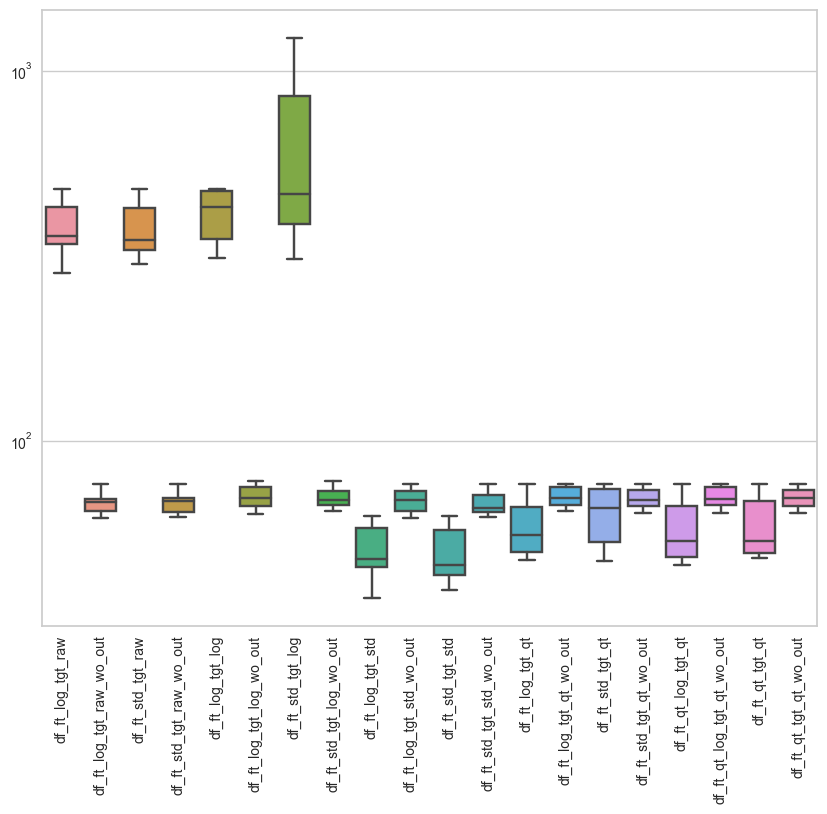

In [50]:
sns.boxplot(df_rmse_prepro, showfliers=False)
plt.xticks(rotation = 90);
plt.yscale('log')
save_fig("Impact des différentes confiurations de pré-traitement sur le score RMSE des modèles")

### Comparaison des scores RMSE des différentes modèles

In [51]:
df_rmse_models = pd.DataFrame(index=[name for name in dict_synth_prepros.keys()])
for model in models_to_train.keys():
    for name, df_tmp in dict_synth_prepros.items():
        df_rmse_models.loc[name, model] = df_tmp.loc[model,'RMSE']

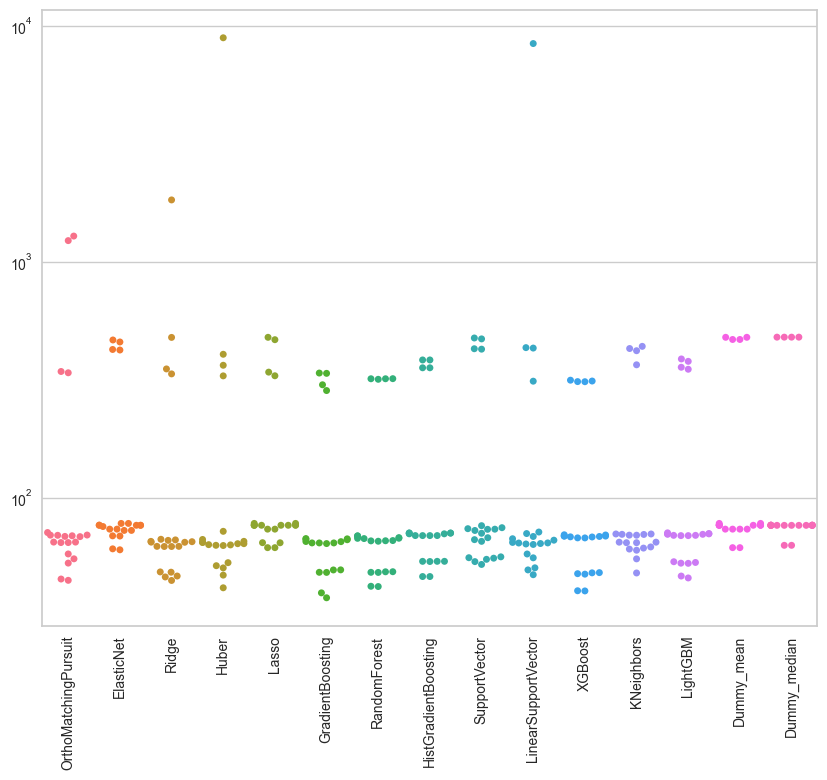

In [52]:
sns.swarmplot(df_rmse_models)
plt.xticks(rotation = 90)
plt.yscale('log')
save_fig("Comparaison des scores RMSE des différents modèles")

# Feature Engineering

Maintenant que nous avons défini les meilleures configurations de traitement de nos variables numériques, nous allons travailler sur nos variables catégorielles dans le but d'améliorer les performances de nos 2 modèles prometteurs avec leurs paramètres par défaut, avant de passer à l'ajustement de leurs hyperparamètres.

In [53]:
promising_models_to_train = {'GradientBoosting':gbr,
                             'XGBoost':xgb
                            }

In [61]:
def cross_val_promising_models(X_train, y_train):
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in promising_models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
    for mdl_name, model in promising_models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_qt = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(target_prepro_std.inverse_transform(y))[test_index], 
                               y_pred=np.abs(target_prepro_std.inverse_transform(y_pred_qt.reshape(-1,1))))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

### YearBuilt

In [64]:
df_year = df.copy()
df_year['YearBuilt'] = pd.cut(df['YearBuilt'], 12)

In [65]:
std_features_year = std_features.copy()
std_features_year.remove('YearBuilt')
cat_features_year = cat_features.copy()
cat_features_year.append('YearBuilt')

In [66]:
std_features_ind_year = [std_features_year.index(ft) for ft in std_features_year]
cat_features_ind_year = [cat_features_year.index(ft) for ft in cat_features_year]

In [67]:
ft_prepro_qt_log_year = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                           ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), std_features_ind_year),
                                           ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind_year)
                                          ])

In [68]:
X_train_year, _, y_train_year, _ = train_test_split(df_year.drop(columns=co2), df_year[co2], test_size=0.2, random_state=SEED)

y_train_year_std = target_prepro_std.transform(pd.DataFrame(y_train_year))

X_train_year_tr_log_qt = ft_prepro_qt_log_year.fit_transform(X_train_year)

cross_val_promising_models(X_train_year_tr_log_qt, y_train_year_std)

MAE        MSE    RMSE adj. R² RMSLE TT(sec)    R²
Model                                                                  
XGBoost            127.4  342963.56  465.46    1.59  1.23    5.06 -0.62
GradientBoosting  142.22  356440.14  533.55    1.92  1.33   21.13 -1.52

In [71]:
df_year = df.copy()
df_year['YearBuilt'] = 2016-df_year['YearBuilt']

In [72]:
X_train_year, _, y_train_year, _ = train_test_split(df_year.drop(columns=co2), df_year[co2], test_size=0.2, random_state=SEED)

y_train_year_std = target_prepro_std.transform(pd.DataFrame(y_train_year))

X_train_year_tr_log_qt = ft_prepro_qt_log.fit_transform(X_train_year)

cross_val_promising_models(X_train_year_tr_log_qt, y_train_year_std)

MAE        MSE    RMSE adj. R² RMSLE TT(sec)   R²
Model                                                                 
GradientBoosting  104.65   94485.19  291.21   -0.05  1.21     0.6  0.1
XGBoost           108.97  112258.31  309.68   -0.05   1.2    0.26  0.1

> Visiblement, les transformations que nous avons imaginé pour la varaible **YearBuilt** ne permettent pas d'améliorer les performances de nos modèles.

## Variables catégorielles

Vérifions s'il nous est possible de diminuer le nombre de modalités dans nos variables catégorielles afin de réduire le nombre de colonnes dans notre jeu de données transformé suite à l'application du *OneHotEncoder* dans l'espoir que cela améliore les résultats de nos modèles.

Gardons également à l'esprit qu'une diminution du nombre de modalités dans une variable catégorielle diminue également sa variance, ce qui peut avoir pour effet de diminuer son pouvoir prédictif selon nos modèles : nous veillerons ainsi à ne regrouper que les modalités décrivant des fonctions de densité de probabilité de la variable cible qui sont très proches.

### Neighborhood

Pour éviter de faire appel à la fonction *train_test_split* et appliquer notre pipeline de pré-traitement des données une multitude de fois par la suite, nous allons travailler directement sur le DataFrame obtenu à partir de notre jeu d'entraînement transformé auquel nous avons assigné les noms de colonnes des variables transformées :

In [73]:
df_train_qt_log = pd.DataFrame(X_train_tr_qt_log, columns=tr_col_names)

x_0 = [element for element in ohenc_col_names if element[:2]=='x0'] #Neighborhood
x_1 = [element for element in ohenc_col_names if element[:2]=='x1'] #PrimaryPropertyType
x_2 = [element for element in ohenc_col_names if element[:2]=='x2'] #LargestPropertyUseType
x_3 = [element for element in ohenc_col_names if element[:2]=='x3'] #SecondLargestPropertyUseType
x_4 = [element for element in ohenc_col_names if element[:2]=='x4'] #ThirdLargestPropertyUseType

dict_cols_grps = {ft:[ft] for ft in num_features}
dict_cols_grps['Neighborhood'] = x_0
dict_cols_grps['PrimaryPropertyType'] = x_1
dict_cols_grps['LargestPropertyUseType'] = x_2
dict_cols_grps['SecondLargestPropertyUseType'] = x_3
dict_cols_grps['ThirdLargestPropertyUseType'] = x_4

In [74]:
df_nh = df[['Neighborhood', co2]].copy()

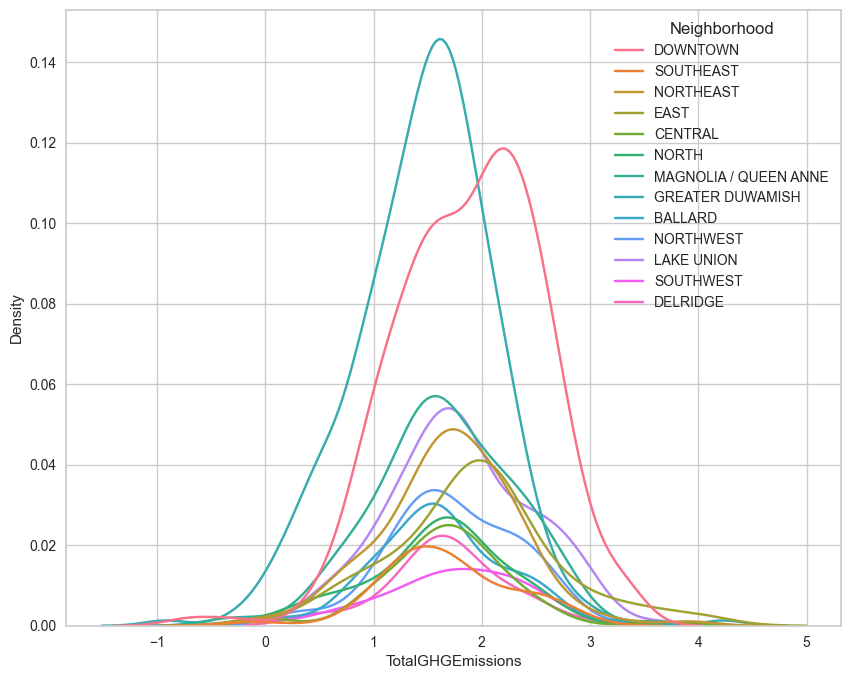

In [75]:
sns.kdeplot(data=df_nh, x=np.log10(df_nh[co2]), hue=df_nh['Neighborhood']);

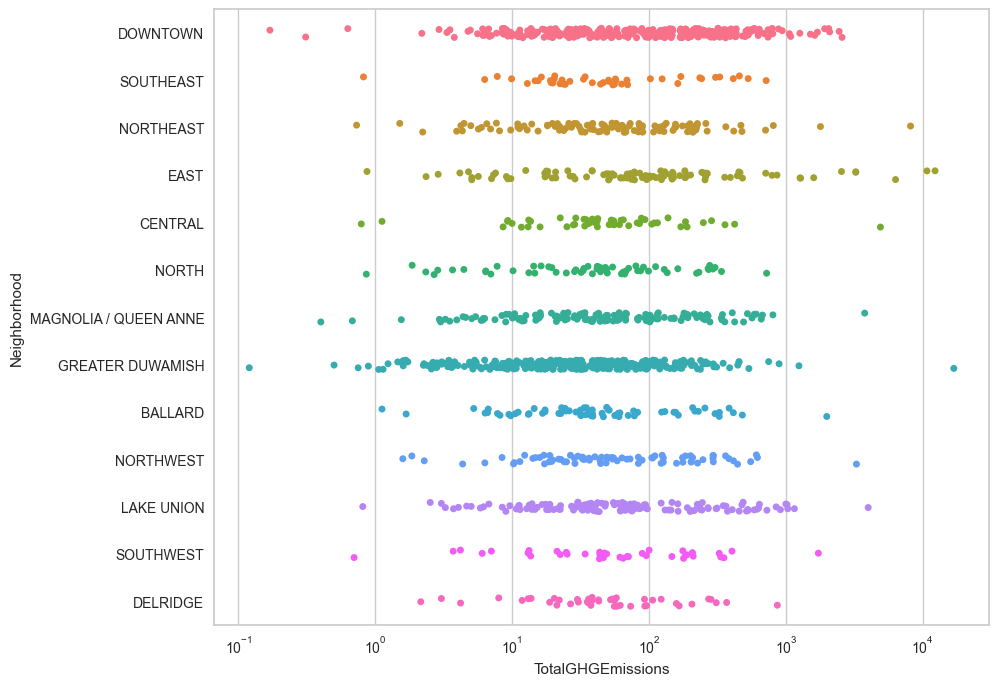

In [76]:
sns.stripplot(data=df_nh['Neighborhood'], y=df_nh['Neighborhood'], x=df_nh[co2], hue=df_nh['Neighborhood'], legend=False)
plt.xscale('log');

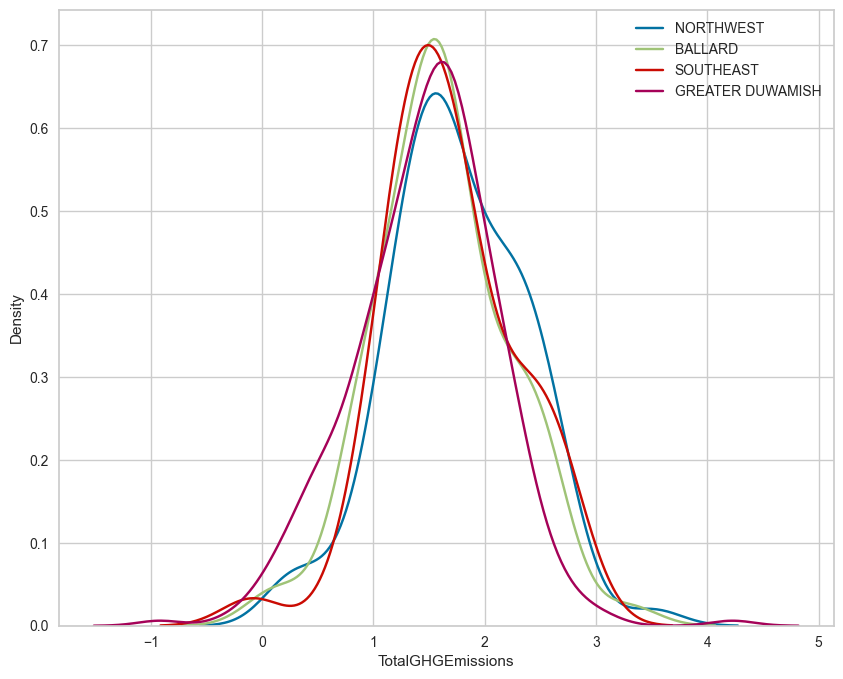

In [106]:
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'NORTHWEST'][co2]), label='NORTHWEST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'BALLARD'][co2]), label='BALLARD')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'SOUTHEAST'][co2]), label='SOUTHEAST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'GREATER DUWAMISH'][co2]), label='GREATER DUWAMISH')
plt.legend();

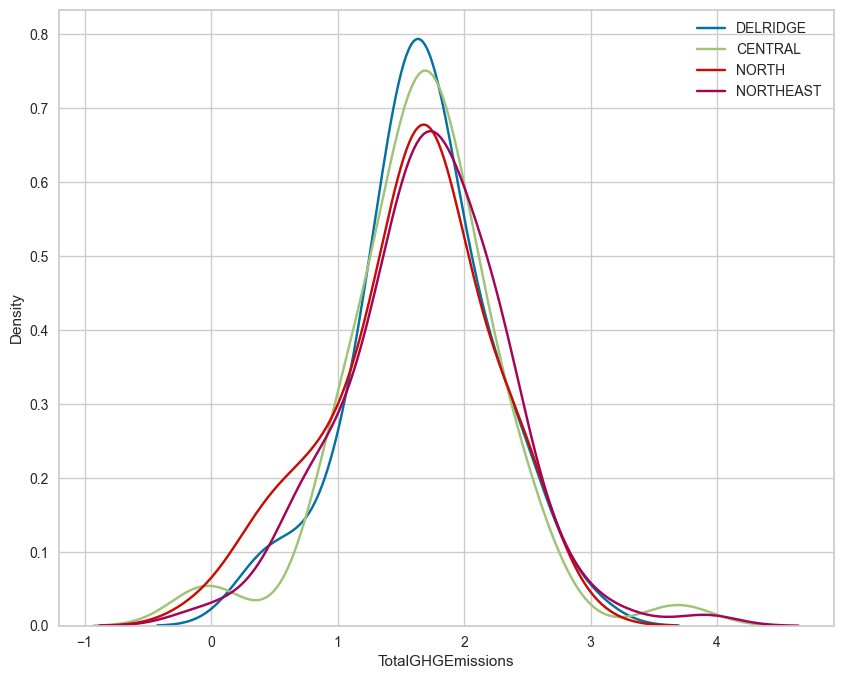

In [104]:
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'DELRIDGE'][co2]), label='DELRIDGE')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'CENTRAL'][co2]), label='CENTRAL')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'NORTH'][co2]), label='NORTH')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'NORTHEAST'][co2]), label='NORTHEAST')
plt.legend();

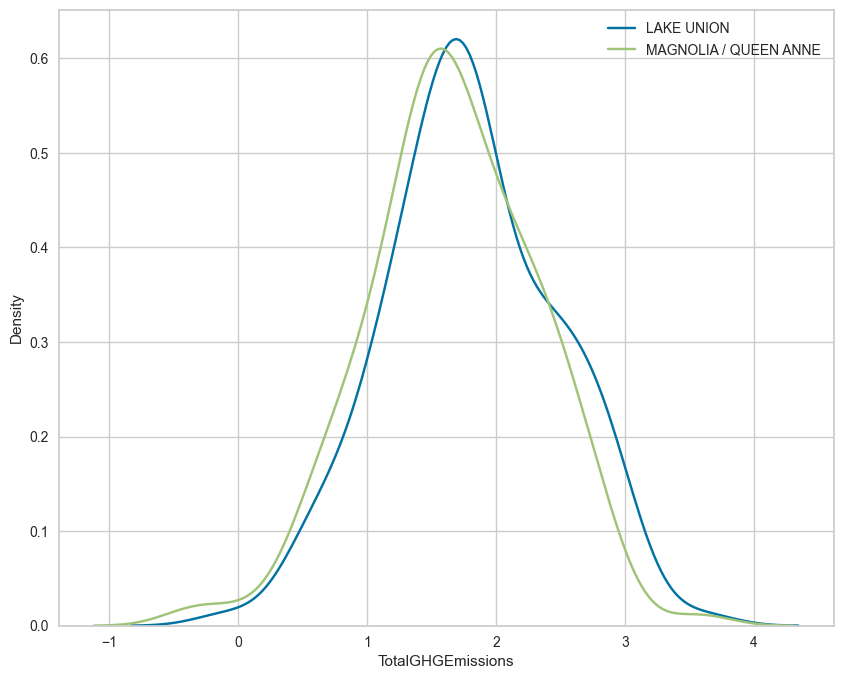

In [100]:
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'LAKE UNION'][co2]), label='LAKE UNION')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'MAGNOLIA / QUEEN ANNE'][co2]), label='MAGNOLIA / QUEEN ANNE')
plt.legend();

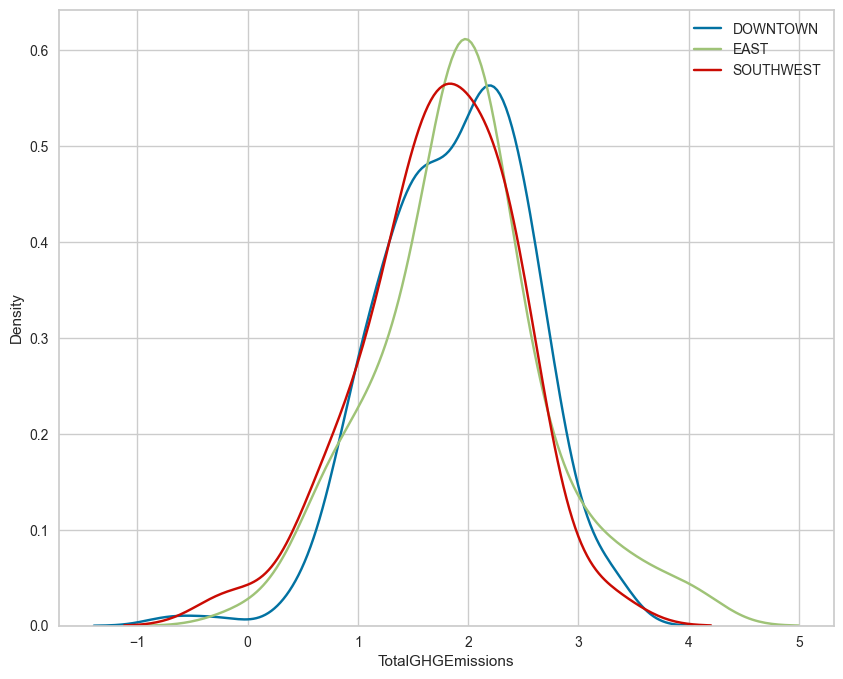

In [107]:
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'DOWNTOWN'][co2]), label='DOWNTOWN')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'EAST'][co2]), label='EAST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'SOUTHWEST'][co2]), label='SOUTHWEST')
plt.legend();

In [121]:
dict_replace_nh = dict()
dict_replace_nh[0] = {'NORTHWEST':'grp_0', 'BALLARD':'grp_0', 'SOUTHEAST':'grp_0','GREATER DUWAMISH':'grp_0'}
dict_replace_nh[1] = {'DELRIDGE':'grp_1', 'CENTRAL':'grp_1', 'NORTHEAST':'grp_1', 'NORTH':'grp_1'}
dict_replace_nh[2] = {'LAKE UNION':'grp_2', 'MAGNOLIA / QUEEN ANNE':'grp_2'}
dict_replace_nh[3] = {'SOUTHWEST':'grp_3', 'EAST':'grp_3', 'DOWNTOWN':'grp_3'}

In [122]:
def replace_cat_nh(df, dict_regroup):
    new_df = df.copy()
    new_cat = ['x0_'+ft for ft in dict_regroup.values()][0]
    old_cats = ['x0_'+ft for ft in dict_regroup.keys()]
    new_df[new_cat] = 0 
    for cat in old_cats:
        new_df[new_cat] += new_df[cat]
        new_df.drop(columns=cat, inplace=True)
    return new_df

In [123]:
for regroup in dict_replace_nh.values():
    
    X_train_nh_tr_log_qt = replace_cat_nh(df_train_qt_log, regroup).to_numpy()
    
    print("\nRegroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_nh_tr_log_qt, y_train_tr_std))


Regroupement de NORTHWEST, BALLARD, SOUTHEAST, GREATER DUWAMISH


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.63  1644.73  38.27   -0.06  0.27    0.56  0.09
XGBoost            14.2  1858.09  40.11   -0.01  0.27     0.3  0.13


Regroupement de DELRIDGE, CENTRAL, NORTHEAST, NORTH


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.53  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.25  0.13


Regroupement de LAKE UNION, MAGNOLIA / QUEEN ANNE


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.31   1405.6  35.83    0.04  0.27    0.56  0.17
XGBoost           14.17  1859.11  40.11    0.01  0.27    0.28  0.15


Regroupement de SOUTHWEST, EAST, DOWNTOWN


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting   13.4  1457.05  36.47    0.08  0.26    0.53  0.21
XGBoost           13.99  1917.14  40.37    0.01  0.27    0.26  0.15

In [124]:
best_rmse[0]

MAE      MSE  RMSE adj. R² RMSLE TT(sec)    R²
Model                                                             
XGBoost           14.09  1876.95  40.2    0.13  0.27    0.26  0.15
GradientBoosting  13.52  1578.26  37.6    0.15  0.27    0.57  0.16

Nous voyons que le second regroupement permet d'améliorer le score **RMSE** de nos modèles.

Essayons de combiner les regroupements de modalités :

In [125]:
X_train_nh_tr_log_qt = df_train_qt_log.copy()

for regroup in dict_replace_nh.values():
    X_train_nh_tr_log_qt = replace_cat_nh(X_train_nh_tr_log_qt, regroup)

cross_val_promising_models(X_train_nh_tr_log_qt.to_numpy(), y_train_tr_std)

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.76  1709.56  39.03    -0.1  0.27    0.55  0.04
XGBoost           13.98  1945.03  40.62    0.02  0.27    0.25  0.15

> Nous n'effectuons que le second regroupement.

In [128]:
df_ft_eng = replace_cat_nh(df_train_qt_log, dict_replace_nh[1])
best_rmse.append(cross_val_promising_models(df_ft_eng.to_numpy(), y_train_tr_std))

### PrimaryPropertyType

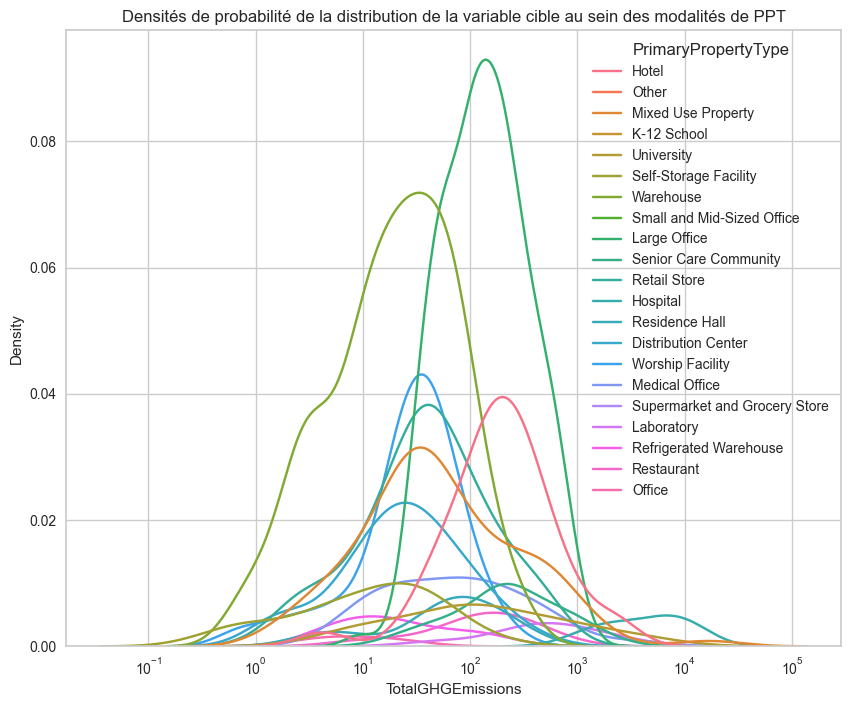

In [129]:
df_ppt = df[['PrimaryPropertyType', co2]].copy()

plt.title("Densités de probabilité de la distribution de la variable cible au sein des modalités de PPT")
sns.kdeplot(data=df_ppt, x=co2, hue=df_ppt['PrimaryPropertyType'], log_scale=True);

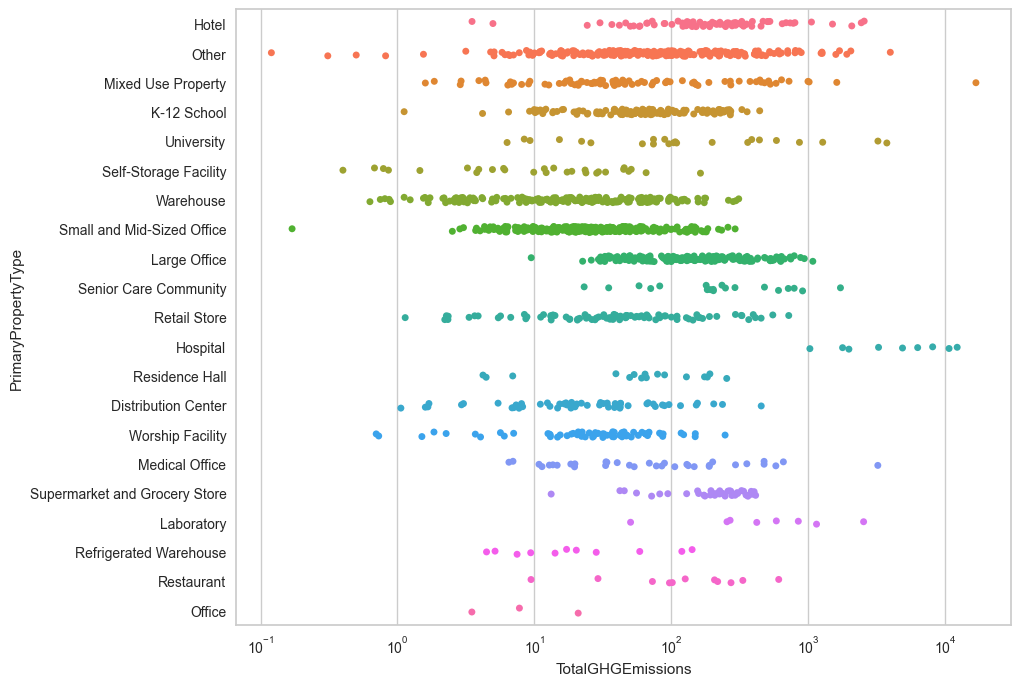

In [130]:
sns.stripplot(data=df_ppt['PrimaryPropertyType'], y=df_ppt['PrimaryPropertyType'], x=df_ppt[co2], hue=df_ppt['PrimaryPropertyType'], legend=False)
plt.xscale('log');

A partir des 2 visualisations précédentes, nous pouvons essayer de regrouper entre elles les modalités ayant une distribution de notre variable cibles qui soient proches :

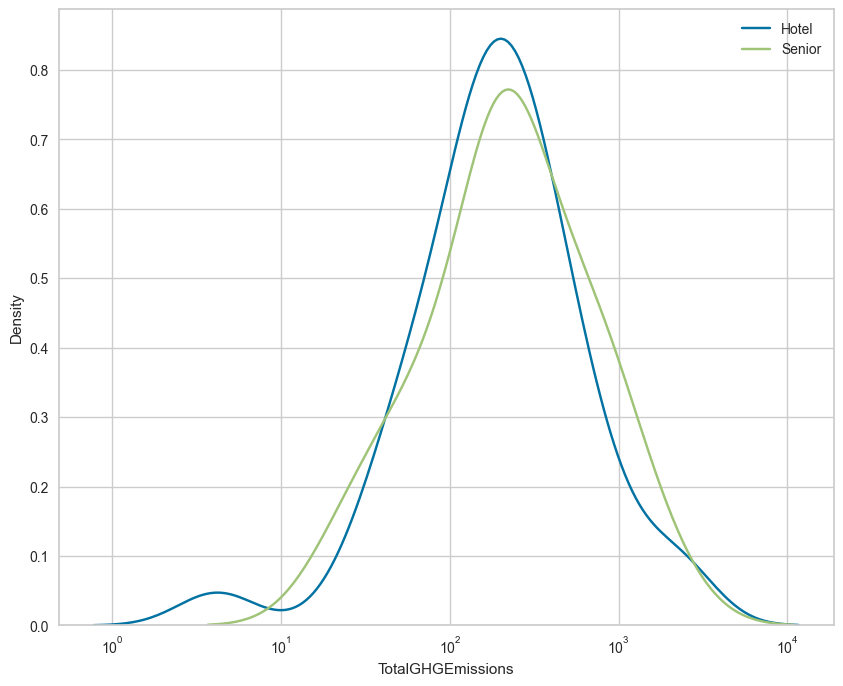

In [131]:
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Hotel'][co2], label='Hotel', log_scale=True)
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Senior Care Community'][co2], label='Senior', log_scale=True)
plt.legend();

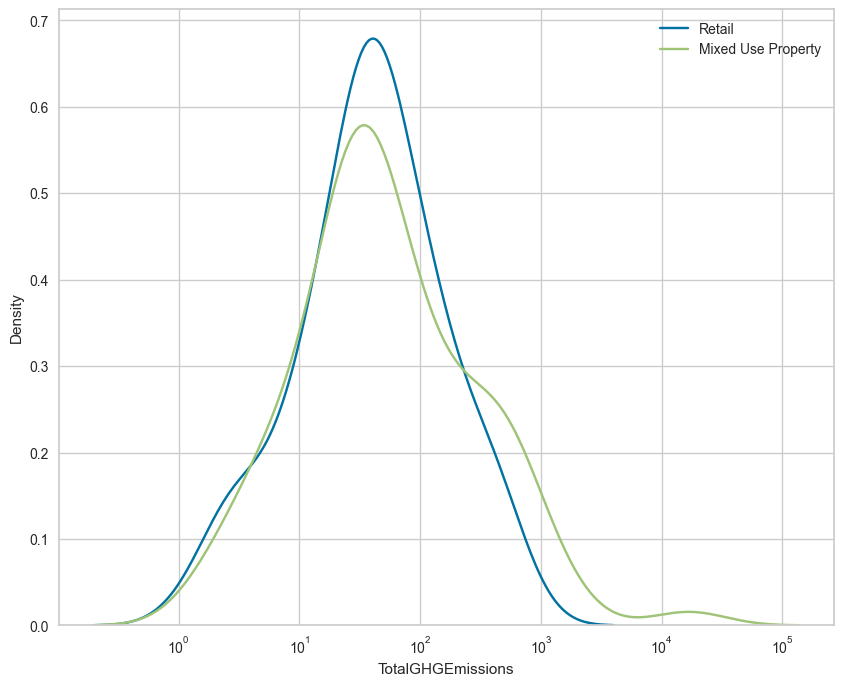

In [132]:
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Retail Store'][co2], label='Retail', log_scale=True)
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Mixed Use Property'][co2], label='Mixed Use Property', log_scale=True)
plt.legend();

In [134]:
dict_replace = dict()
dict_replace[0] = {'Senior Care Community':'grp_0','Hotel':'grp_0'}
dict_replace[1] = {'Retail Store':'grp_1', 'Mixed Use Property':'grp_1'}

In [135]:
def replace_cat_ppt(df, dict_regroup):
    new_df = df.copy()
    new_cat = ['x1_'+ft for ft in dict_regroup.values()][0]
    old_cats = ['x1_'+ft for ft in dict_regroup.keys()]
    new_df[new_cat] = 0 
    for cat in old_cats:
        new_df[new_cat] += new_df[cat]
        new_df.drop(columns=cat, inplace=True)
    return new_df

In [136]:
for regroup in dict_replace.values():
    
    X_train_ppt_tr_log_qt = replace_cat_ppt(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup]))
    
    display(cross_val_promising_models(X_train_ppt_tr_log_qt, y_train_tr_std))

Regroupement de Senior Care Community, Hotel


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.53  1475.48  36.78    0.03  0.27    0.58  0.16
XGBoost           14.06  1824.95   39.8    0.05  0.27    0.25  0.18

Regroupement de Retail Store, Mixed Use Property


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.44   1511.2  36.76   -0.02  0.26    0.57  0.12
XGBoost           14.33  1983.52  41.15    -0.1  0.27    0.25  0.05

In [137]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

Aucun des regroupements ne nous permet d'améliorer significativement le socre **RMSE**.
Vérifions si ce peut être le cas en les réalisant tous:

In [138]:
X_train_ppt_tr_log_qt = df_ft_eng.copy()
for regroup in dict_replace.values():
    X_train_ppt_tr_log_qt = replace_cat_ppt(X_train_ppt_tr_log_qt, regroup)

cross_val_promising_models(X_train_ppt_tr_log_qt.to_numpy(), y_train_tr_std)

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.78  1598.06  38.24   -0.03  0.27    0.59  0.11
XGBoost            14.2  1931.84  40.83   -0.08  0.27    0.27  0.06

Nous n'obtenons pas de meilleurs résultats en regroupant les modalités de la variable **PrimaryPropertyType**.

### LargestPropertyTypeUse

Étant donné le grand nombre de modalités, ici, nous avons tout intérêt à commencer à intégrer dans de plus grandes catégories les modalités ayant avec un effectif unitaire :

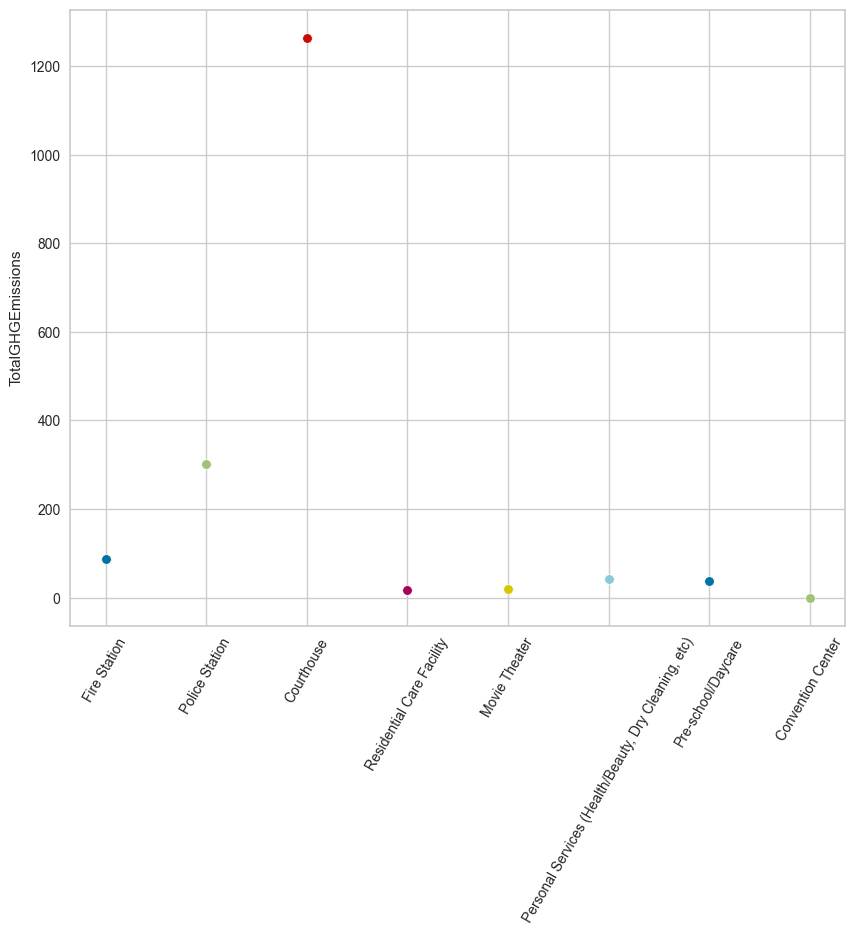

In [139]:
list_cat_unit = list(df['LargestPropertyUseType'].value_counts()[df['LargestPropertyUseType'].value_counts()==1].index)
for cat in list_cat_unit:
    sns.scatterplot(x=list_cat_unit.index(cat),y=df[df['LargestPropertyUseType']==cat][co2])

plt.xticks(ticks=[list_cat_unit.index(cat) for cat in list_cat_unit], labels=list_cat_unit)
plt.xticks(rotation=60);

In [140]:
for cat in list_cat_unit:
    print(cat)
    display(df[df[co2] > 0.99*df[df['LargestPropertyUseType'] == cat][co2].values[0]].sort_values(by=co2, ascending=True)[:15])

Fire Station


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
386                     74864.0  47.61440 -122.30982                1.0   
830                     21571.0  47.61065 -122.32125                1.0   
659                     38939.0  47.61607 -122.34449                1.0   
609                     48001.0  47.51127 -122.28100                1.0   
856                    120548.0  47.62004 -122.33807                1.0   
898                     45680.0  47.68566 -122.31849                1.0   
1343                    62400.0  47.66450 -122.31224                1.0   
56                      54984.0  47.60823 -122.30956                1.0   
485                    178625.0  47.61813 -122.35833                1.0   
90                      70609.0  47.72551 -122.34230                1.0   
600                     50956.0  47.69054 -122.29705                1.0   
707                     49744.0  47.56504 -122.38455                1.0   
538                     81873.0  47.60663 -122.32157                1.0   
225                     89200.0  47.66024 -122.31278                1.0   
556                     55000.0  47.52549 -122.33064                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
386                3                   80004                   0   
830                2                   20570               10285   
659                2                   37740                   0   
609                1                   48001                   0   
856                6                   29910              100800   
898                3                   45680                   0   
1343               2                   78401                   0   
56                 2                   54984                   0   
485                7                  197203               80283   
90                 3                   69138                   0   
600                1                   46732                   0   
707                3                   49744                   0   
538                5                   89025               99314   
225                2                   89200                   0   
556                1                   54880                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
386              80004                              0.0   
830              30855                              0.0   
659              37740                              0.0   
609              48001                              0.0   
856             130710                          88960.0   
898              45680                              0.0   
1343             78401                           9940.0   
56               54984                              0.0   
485             277486                          87624.0   
90               69138                              0.0   
600              46732                              0.0   
707              49744                              0.0   
538             188339                          67000.0   
225              89200                              0.0   
556              54880                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt      Neighborhood  \
386                              0.0       1926           CENTRAL   
830                              0.0       1962              EAST   
659                              0.0       1922          DOWNTOWN   
609                              0.0       1967  GREATER DUWAMISH   
856                           5436.0       2013        LAKE UNION   
898                              0.0       1908             NORTH   
1343                          4960.0       1927         NORTHEAST   
56                               0.0       1962           CENTRAL   
485                          14653.0       1986          DOWNTOWN   
90                               0.0       2002         NORTHWEST   
600         

Police Station


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
1243                    29640.0  47.59886 -122.31678                1.0   
185                     69400.0  47.60729 -122.34211                1.0   
5                       88830.0  47.61623 -122.33657                1.0   
1487                    51841.0  47.71864 -122.31200                1.0   
973                     42850.0  47.66646 -122.38263                1.0   
421                     54434.0  47.52095 -122.26825                1.0   
140                    123920.0  47.62972 -122.32906                1.0   
468                     50000.0  47.56797 -122.36711                1.0   
34                     616000.0  47.51138 -122.28875                3.0   
193                    622034.0  47.61316 -122.33430                1.0   
510                     97500.0  47.62890 -122.32877                1.0   
264                     87391.0  47.60991 -122.33687                1.0   
208                   1011135.0  47.60505 -122.33427                1.0   
1504                   146363.0  47.55960 -122.38459                1.0   
312                    102653.0  47.66057 -122.36857                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
1243               2                   26579               21384   
185                2                   69400                   0   
5                  2                   60090               37198   
1487               1                   51400                   0   
973                3                   40836                4914   
421                1                   61053                   0   
140                5                   93920               30000   
468                3                   57236               11527   
34                 2                  714095                   0   
193               33                  791396                   0   
510                5                  183574              103650   
264               10                  130513                   0   
208               47                 1323055                   0   
1504               6                  146363                   0   
312                1                  164437                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
1243             47963                           6000.0   
185              69400                              0.0   
5                97288                              0.0   
1487             51400                              0.0   
973              45750                           2900.0   
421              61053                              0.0   
140             123920                          30000.0   
468              68763                          11527.0   
34              714095                         276000.0   
193             791396                         132465.0   
510             287224                          88051.0   
264             130513                          32264.0   
208            1323055                         272682.0   
1504            146363                              0.0   
312             164437                          74102.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt      Neighborhood  \
1243                             0.0       1991          DOWNTOWN   
185                              0.0       1980          DOWNTOWN   
5                                0.0       1999          DOWNTOWN   
1487                             0.0       2011             NORTH   
973                              0.0       1900           BALLARD   
421                              0.0       2002         SOUTHEAST   
140                              0.0       1998        LAKE UNION   
468                              0.0       2001          DELRIDGE   
34                           71000.0       1961  GREATER DUWAMISH   
193                          33110.0       1976          DOWNTOWN   
510         

Courthouse


LargestPropertyUseTypeGFA   Latitude   Longitude  NumberofBuildings  \
19                     537150.0  47.602650 -122.330510                1.0   
310                    158738.0  47.609530 -122.327930                1.0   
1522                   472384.0  47.617484 -122.321853                1.0   
257                    310000.0  47.609680 -122.333790                1.0   
1501                   160482.0  47.609890 -122.326590                1.0   
352                    119815.0  47.607400 -122.337770                1.0   
20                     385274.0  47.603780 -122.328420                1.0   
57                     296313.0  47.558370 -122.377510                1.0   
1502                   241500.0  47.662010 -122.283860                1.0   
519                    218997.0  47.614380 -122.338710                1.0   
94                     302661.0  47.667370 -122.379560                4.0   
115                    250000.0  47.615980 -122.334480                1.0   
2                      756493.0  47.613930 -122.338100                1.0   
47                     994212.0  47.610870 -122.333390                1.0   
1490                   181930.0  47.604270 -122.323110                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
19                10                  540360                   0   
310                8                  158738                   0   
1522               3                  428347                   0   
257               21                  305548                   0   
1501               7                  267470                   0   
352                6                  154660                   0   
20                19                  385274                   0   
57                 5                  217603                   0   
1502               8                  330000                   0   
519               33                  429405                   0   
94                 5                  285333                   0   
115               11                  230638               68432   
2                 41                  759392              196718   
47                34                  847518              146694   
1490               8                  178000                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
19              540360                              0.0   
310             158738                              0.0   
1522            428347                              0.0   
257             305548                              0.0   
1501            267470                         106988.0   
352             154660                          63101.0   
20              385274                              0.0   
57              217603                              0.0   
1502            330000                              0.0   
519             429405                         210409.0   
94              285333                         148865.0   
115             299070                              0.0   
2               956110                              0.0   
47              994212                         117668.0   
1490            178000                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt Neighborhood  \
19                               0.0       1916     DOWNTOWN   
310                              0.0       1975         EAST   
1522                             0.0       1925         EAST   
257                              0.0       1930     DOWNTOWN   
1501                             0.0       2012         EAST   
352                          26380.0       1991     DOWNTOWN   
20                               0.0       1985     DOWNTOWN   
57                               0.0       1922    SOUTHWEST   
1502                             0.0       2013    NORTHEAST   
519                              0.0       1981     DOWNTOWN   
94                               0.

Residential Care Facility


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
805                     25557.0  47.72299 -122.34293                1.0   
174                     65310.0  47.59096 -122.29985                1.0   
1057                    18133.0  47.63310 -122.37582                1.0   
794                     40067.0  47.64976 -122.35684                1.0   
1517                    24520.0  47.58430 -122.32229                1.0   
798                     34545.0  47.64934 -122.35592                1.0   
593                     80360.0  47.70799 -122.30185                1.0   
81                      60725.0  47.57324 -122.29058                1.0   
439                     78814.0  47.58781 -122.33264                1.0   
1133                    41430.0  47.57747 -122.32844                1.0   
839                     10109.0  47.62296 -122.33884                1.0   
651                     49800.0  47.61595 -122.34756                1.0   
975                     22282.0  47.66431 -122.37988                1.0   
1088                    13000.0  47.58220 -122.32100                1.0   
982                     24052.0  47.68582 -122.33709                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
805                4                   25557                   0   
174                2                   64414                   0   
1057               1                   47554                   0   
794                3                   40067                   0   
1517               2                   56988                   0   
798                3                   34545                   0   
593                4                   80360                   0   
81                 2                   58933                   0   
439                1                   78814                   0   
1133               1                   41248                   0   
839                2                   25920                   0   
651                3                   49800                7820   
975                1                   22282                   0   
1088               1                   21349                   0   
982                3                   33062               22850   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
805              25557                              0.0   
174              64414                              0.0   
1057             47554                           8679.0   
794              40067                              0.0   
1517             56988                              0.0   
798              34545                              0.0   
593              80360                              0.0   
81               58933                              0.0   
439              78814                              0.0   
1133             41248                              0.0   
839              25920                           7016.0   
651              57620                           7820.0   
975              22282                              0.0   
1088             21349                           8349.0   
982              55912                          23501.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
805                              0.0       1970              NORTHWEST   
174                              0.0       1991                CENTRAL   
1057                          2388.0       1931  MAGNOLIA / QUEEN ANNE   
794                              0.0       1986  MAGNOLIA / QUEEN ANNE   
1517                             0.0       2014       GREATER DUWAMISH   
798                              0.0       1980  MAGNOLIA / QUEEN ANNE   
593                              0.0       1987                  NORTH   
81                               0.0       1991              SOUTHEAST   
439                              0.0       1954       GREATER DUWAMISH   
1133                           

Movie Theater


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
1398                    22962.0  47.58671 -122.30201                1.0   
799                     70296.0  47.64865 -122.35435                1.0   
1171                    33392.0  47.70197 -122.34219                1.0   
1076                    23923.0  47.69061 -122.31992                1.0   
1069                    35693.0  47.60320 -122.33663                1.0   
1409                    33708.0  47.61314 -122.32262                1.0   
1085                    24023.0  47.55498 -122.32497                1.0   
1139                    27642.0  47.66159 -122.28606                2.0   
423                     78564.0  47.59895 -122.33379                1.0   
1156                    23904.0  47.69734 -122.34639                1.0   
1357                    25880.0  47.51950 -122.26935                1.0   
723                     17804.0  47.58528 -122.30500                1.0   
498                     44300.0  47.58096 -122.32313                1.0   
1147                    22992.0  47.58661 -122.32810                1.0   
425                     63871.0  47.59856 -122.33379                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
1398               2                   22952                   0   
799                3                   70296                   0   
1171               1                   33392                   0   
1076               2                   23923                   0   
1069               3                   32160                   0   
1409               3                   33708                   0   
1085               1                   24291                   0   
1139               4                   22356               14576   
423                5                   78920                   0   
1156               1                   66704                   0   
1357               2                   25880                   0   
723                1                   29740                   0   
498                1                   84420                   0   
1147               1                   23792                   0   
425                6                   73260                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
1398             22952                              0.0   
799              70296                              0.0   
1171             33392                              0.0   
1076             23923                              0.0   
1069             32160                          14219.0   
1409             33708                              0.0   
1085             24291                              0.0   
1139             36932                              0.0   
423              78920                              0.0   
1156             66704                          18500.0   
1357             25880                              0.0   
723              29740                          12208.0   
498              84420                          24838.0   
1147             23792                            800.0   
425              73260                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
1398                             0.0       1963              SOUTHEAST   
799                              0.0       1980  MAGNOLIA / QUEEN ANNE   
1171                             0.0       1986              NORTHWEST   
1076                             0.0       1931                  NORTH   
1069                             0.0       1906               DOWNTOWN   
1409                             0.0       1912                   EAST   
1085                             0.0       1953       GREATER DUWAMISH   
1139                             0.0       1987              NORTHEAST   
423                              0.0       1904               DOWNTOWN   
1156                         18

Personal Services (Health/Beauty, Dry Cleaning, etc)


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
719                     51704.0  47.58547 -122.31510                1.0   
655                     25920.0  47.61267 -122.33852                1.0   
1410                    47661.0  47.73368 -122.31366                1.0   
106                     66994.0  47.61224 -122.29087                1.0   
1172                    32040.0  47.53160 -122.33300                1.0   
534                     95942.0  47.60576 -122.33922                1.0   
339                    325424.0  47.56419 -122.34262                1.0   
1340                    22452.0  47.54774 -122.32091                1.0   
1250                    25406.0  47.71620 -122.29560                1.0   
1150                    49825.0  47.60592 -122.31367                1.0   
303                     85339.0  47.69999 -122.32663                1.0   
786                     10155.0  47.65115 -122.35024                1.0   
630                     20920.0  47.61636 -122.35094                1.0   
1516                   191333.0  47.58872 -122.33475                1.0   
1232                    28470.0  47.59881 -122.30189                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
719                1                   51704                   0   
655                2                   30438               13660   
1410               2                   47237                   0   
106                3                   66994                   0   
1172               1                   32000                   0   
534                7                  122356                   0   
339                1                  243044                   0   
1340               3                   22452                   0   
1250               1                   25406                   0   
1150               5                   49825               22788   
303                6                   88774                   0   
786                2                   20516                   0   
630                2                   20920                   0   
1516               7                  187027              146687   
1232               1                   30630                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
719              51704                              0.0   
655              44098                          13155.0   
1410             47237                              0.0   
106              66994                              0.0   
1172             32000                              0.0   
534             122356                          15523.0   
339             243044                              0.0   
1340             22452                              0.0   
1250             25406                              0.0   
1150             72613                          22788.0   
303              88774                              0.0   
786              20516                           8000.0   
630              20920                              0.0   
1516            333714                         133432.0   
1232             30630                           2442.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt      Neighborhood  \
719                              0.0       1971  GREATER DUWAMISH   
655                              0.0       1925          DOWNTOWN   
1410                             0.0       1948             NORTH   
106                              0.0       2002           CENTRAL   
1172                             0.0       1966  GREATER DUWAMISH   
534                            182.0       1910          DOWNTOWN   
339                              0.0       1999  GREATER DUWAMISH   
1340                             0.0       1992  GREATER DUWAMISH   
1250                             0.0       1960             NORTH   
1150                             0.0       1984           CENTRAL   
303         

Pre-school/Daycare


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
617                     28492.0  47.67528 -122.40836                1.0   
1484                    14877.0  47.58230 -122.32937                1.0   
1417                    34856.0  47.63286 -122.36141                1.0   
1519                    44162.0  47.51377 -122.34328                1.0   
1500                   138602.0  47.53246 -122.33304                2.0   
1413                    26373.0  47.66295 -122.31494                1.0   
1342                    14585.0  47.66188 -122.31279                1.0   
508                     77174.0  47.64932 -122.35187                1.0   
1403                    11093.0  47.60745 -122.32542                1.0   
1137                    20484.0  47.55464 -122.31576                1.0   
1025                    28109.0  47.57058 -122.35626                1.0   
373                     28442.0  47.61552 -122.31744                1.0   
948                     15000.0  47.66984 -122.38420                1.0   
21                      58916.0  47.54576 -122.26853                1.0   
383                     60676.0  47.59367 -122.30957                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
617                2                   28492                   0   
1484               3                   21947                   0   
1417               2                   36771                   0   
1519               2                   44162                   0   
1500               2                  137138                   0   
1413               3                   26373                   0   
1342               4                   33910                   0   
508                2                   51374               25800   
1403               4                   27800                   0   
1137               1                   20484                   0   
1025               2                   28109                   0   
373                2                   55916               19928   
948                1                   15000               15576   
21                 2                   56228                   0   
383                2                   62220                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
617              28492                              0.0   
1484             21947                          12023.0   
1417             36771                              0.0   
1519             44162                          15761.0   
1500            137138                              0.0   
1413             26373                              0.0   
1342             33910                          14462.0   
508              77174                              0.0   
1403             27800                              0.0   
1137             20484                              0.0   
1025             28109                              0.0   
373              75844                          28441.0   
948              30576                           3100.0   
21               56228                              0.0   
383              62220                          13780.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
617                              0.0       1978                BALLARD   
1484                          4920.0       2004       GREATER DUWAMISH   
1417                             0.0       1956  MAGNOLIA / QUEEN ANNE   
1519                             0.0       2010               DELRIDGE   
1500                             0.0       2012       GREATER DUWAMISH   
1413                             0.0       1938              NORTHEAST   
1342                             0.0       1953              NORTHEAST   
508                              0.0       2000             LAKE UNION   
1403                             0.0       1912                   EAST   
1137                           

Convention Center


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
1212                    24717.0  47.58788 -122.33458                1.0   
823                     25000.0  47.61119 -122.33581                1.0   
863                     24019.0  47.60711 -122.33886                1.0   
964                     39952.0  47.64418 -122.37587                1.0   
1489                    39212.0  47.54277 -122.31626                1.0   
701                     24000.0  47.60528 -122.33627                1.0   
963                     30989.0  47.64455 -122.37581                1.0   
980                     23772.0  47.51709 -122.37797                1.0   
1393                    20039.0  47.66146 -122.27880                1.0   
1218                    22752.0  47.55608 -122.33880                1.0   
1216                    21018.0  47.61234 -122.31628                1.0   
934                     20140.0  47.65022 -122.34174                1.0   
727                     20047.0  47.56979 -122.29234                1.0   
996                     31360.0  47.70782 -122.31873                2.0   
1442                    23040.0  47.61481 -122.31536                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
1212               3                   27690                   0   
823                3                   57720                   0   
863                3                   49760                   0   
964                3                   39952                   0   
1489               2                   39212                   0   
701                5                   33300                   0   
963                3                   30989                   0   
980                1                   23772                   0   
1393               2                   20039                   0   
1218               1                   24617                   0   
1216               1                   24248                   0   
934                2                   20140                   0   
727                2                   20047                   0   
996                2                   33344                   0   
1442               2                   23040                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
1212             27690                              0.0   
823              57720                              0.0   
863              49760                              0.0   
964              39952                              0.0   
1489             39212                              0.0   
701              33300                           6000.0   
963              30989                              0.0   
980              23772                              0.0   
1393             20039                              0.0   
1218             24617                              0.0   
1216             24248                           3230.0   
934              20140                              0.0   
727              20047                              0.0   
996              33344                            984.0   
1442             23040                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
1212                             0.0       1910       GREATER DUWAMISH   
823                              0.0       1903               DOWNTOWN   
863                              0.0       1900               DOWNTOWN   
964                              0.0       1915  MAGNOLIA / QUEEN ANNE   
1489                             0.0       1906       GREATER DUWAMISH   
701                              0.0       1900               DOWNTOWN   
963                              0.0       1980  MAGNOLIA / QUEEN ANNE   
980                              0.0       1971              SOUTHWEST   
1393                             0.0       1954              NORTHEAST   
1218                           

Nous pouvons intégrer la modalité **Fire Station** dans la catégorie **Medical Office** car c'est celle présentant un bâtiment dont la valeur cible est la plus proche, et nous procédons de même pour les autres modalités unitaires :

In [141]:
df_lput = df[['LargestPropertyUseType', co2]].copy()

In [150]:
dict_replace = dict()

dict_replace[0] = {'Fire Station':'Other'}
dict_replace[1] = {'Police Station':'Other - Entertainment/Public Assembly'}
dict_replace[2] = {'Courthouse':'Urgent Care/Clinic/Other Outpatient'}
dict_replace[3] = {'Movie Theater':'Office'}
dict_replace[4] = {'Personal Services (Health/Beauty, Dry Cleaning, etc)':'Office'}
dict_replace[5] = {'Convention Center':'Other'}

In [151]:
def replace_cat_lput_unit(df, dict_regroup):
    new_df = df.copy()
    new_cat = ['x2_'+ft for ft in dict_regroup.values()][0]
    old_cat = ['x2_'+ft for ft in dict_regroup.keys()][0]
    new_df[new_cat] += new_df[old_cat]
    new_df.drop(columns=[old_cat], inplace=True)
    return new_df

In [152]:
for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput_unit(df_ft_eng, regroup).to_numpy()
    
    for key, value in regroup.items():
    
        print("Regroupement de "+', '.join([key, value]))
    
        display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_std))

Regroupement de Fire Station, Other


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.38  1491.74   36.8    0.02  0.27    0.57  0.16
XGBoost           14.24  1861.35  40.19   -0.02  0.27    0.28  0.12

Regroupement de Police Station, Other - Entertainment/Public Assembly


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.52  1455.34   35.9    -0.0  0.27     0.6  0.13
XGBoost           14.21  1873.63  40.24     0.0  0.27     0.3  0.14

Regroupement de Courthouse, Urgent Care/Clinic/Other Outpatient


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.39  1485.26  36.67    0.07  0.26    0.57  0.20
XGBoost           14.11  1866.98  40.18   -0.01  0.27    0.55  0.13

Regroupement de Movie Theater, Office


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.62  1492.43  36.92    0.03  0.27    0.73  0.16
XGBoost           14.11  1876.55  40.21   -0.01  0.27    0.31  0.13

Regroupement de Personal Services (Health/Beauty, Dry Cleaning, etc), Office


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.69  1656.87  38.58   -0.08  0.27    0.65  0.07
XGBoost           14.17  1856.67  40.12   -0.01  0.27    0.29  0.13

Regroupement de Convention Center, Other


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.52  1514.86  37.36   -0.09  0.27    0.55  0.06
XGBoost           14.25  1942.09  40.87   -0.11  0.27    0.26  0.04

In [153]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

> Aucun des regroupements ci-haut ne permet d'améliorer significativement le score **RMSE**, voyons s'il en est de même en les réalisant tous.

In [154]:
X_train_lput_tr_log_qt = df_ft_eng.copy()
for regroup in dict_replace.values():
    X_train_lput_tr_log_qt = replace_cat_lput_unit(X_train_lput_tr_log_qt, regroup)

cross_val_promising_models(X_train_lput_tr_log_qt.to_numpy(), y_train_tr_std)

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.56  1657.64  38.66   -0.13  0.27    0.59  0.02
XGBoost           14.28  1956.85  40.98    -0.1  0.27    0.25  0.05

> Nous n'observons pas d'amélioration du score **RMSE** en effectuant tous les regroupements ci-avant.

Essayons d'opérer des regroupements entre les modalités ayant un effectif de 2 observations et 3 observations:

In [158]:
list_2_3_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df['LargestPropertyUseType'].value_counts()[df['LargestPropertyUseType'].value_counts()==3].index)
list_2_3_cat.remove("Other - Utility")

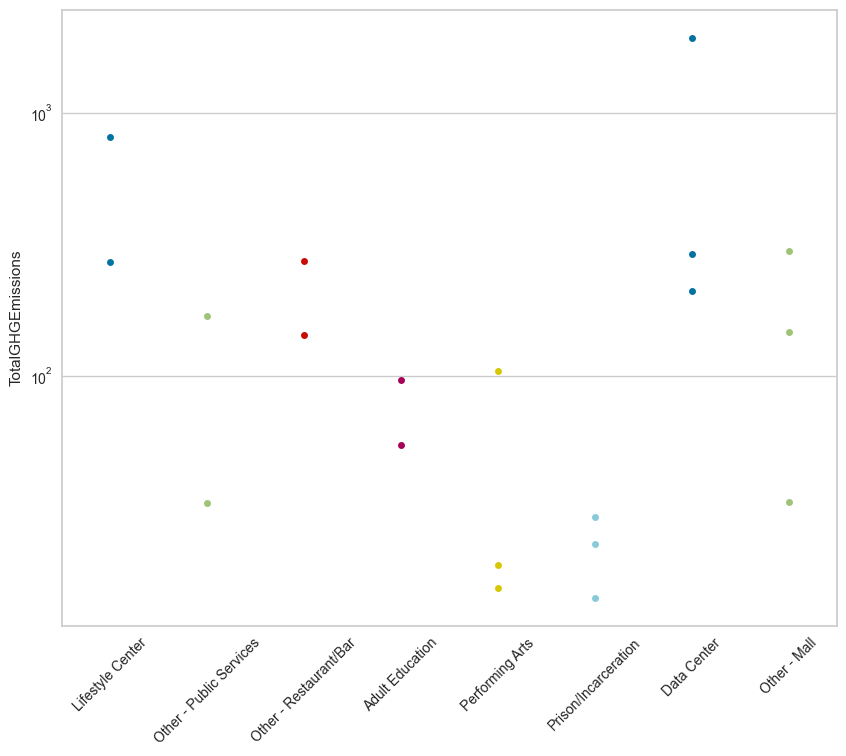

In [159]:
for cat in list_2_3_cat:
    sns.swarmplot(x=list_2_3_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][co2])

plt.xticks(ticks=[list_2_3_cat.index(cat) for cat in list_2_3_cat], labels=list_2_3_cat)
plt.xticks(rotation=45);
plt.yscale('log')

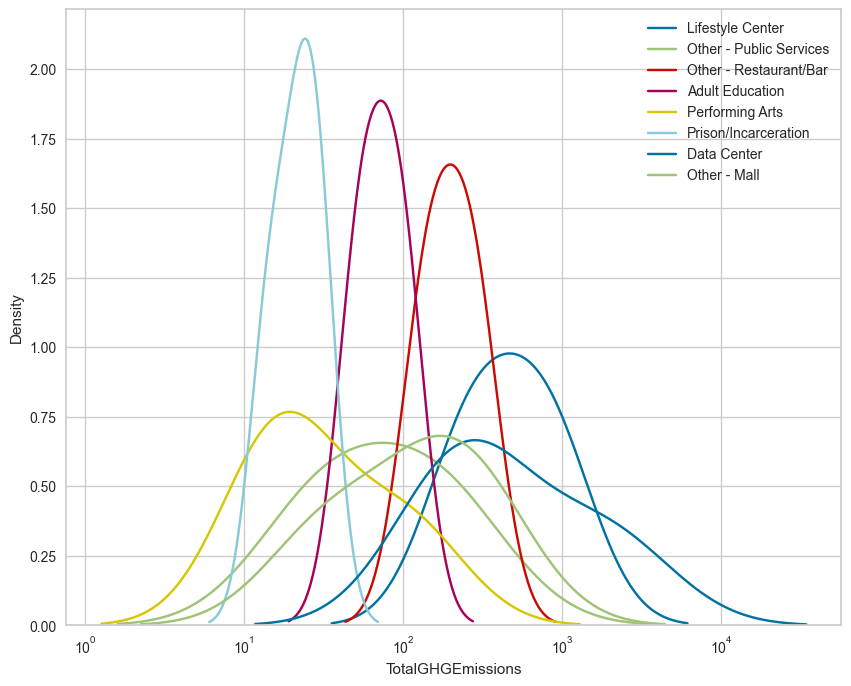

In [160]:
for cat in list_2_3_cat:
    sns.kdeplot(df[df['LargestPropertyUseType']==cat][co2], label=cat, log_scale=True)
plt.legend();

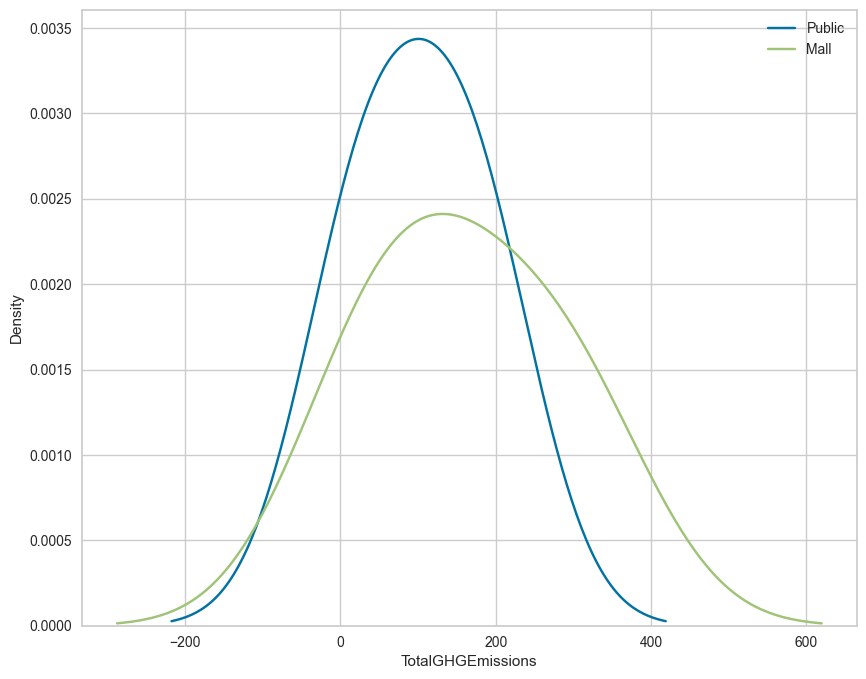

In [167]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Public Services'][co2], label='Public')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Mall'][co2], label='Mall')
plt.legend();

In [162]:
def replace_cat_lput(df, dict_regroup):
    new_df = df.copy()
    new_cat = ['x2_'+ft for ft in dict_regroup.values()][0]
    old_cats = ['x2_'+ft for ft in dict_regroup.keys()]
    new_df[new_cat] = 0 
    for cat in old_cats:
        new_df[new_cat] += new_df[cat]
        new_df.drop(columns=cat, inplace=True)
    return new_df

In [165]:
dict_replace.clear()
dict_replace[0] = {'Other - Public Services':'grp_1', 'Other - Mall':'grp_1'}

In [166]:
for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_std))

Regroupement de Other - Public Services, Other - Mall


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.42  1468.49  36.56    0.08  0.26    0.59  0.21
XGBoost           14.17  1867.23  40.21   -0.01  0.27    0.26  0.13

In [168]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

> Le regroupement ci-haut ne permet pas d'améliorer le score **RMSE**, voyons s'il en est de même en les réalisant tous.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 4 observations:

In [192]:
list_2_3_4_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==3].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==4].index)
list_2_3_4_cat.remove("Other - Utility")
list_2_3_4_cat.remove("Other - Restaurant/Bar")
list_2_3_4_cat.remove("Other - Public Services")

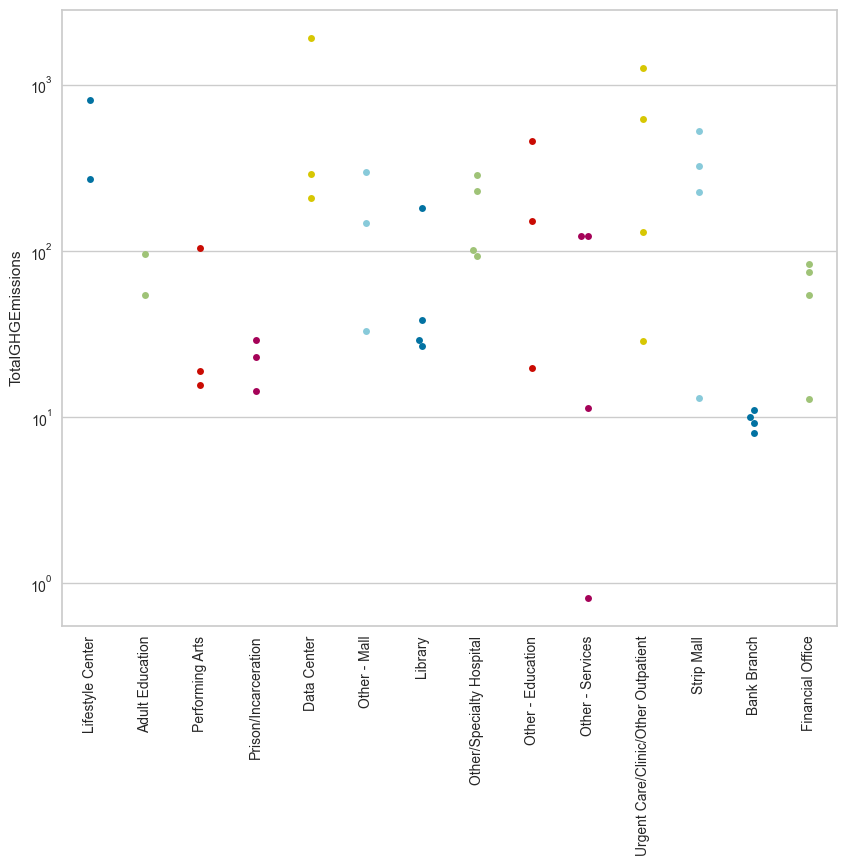

In [193]:
for cat in list_2_3_4_cat:
    sns.swarmplot(x=list_2_3_4_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][co2])

plt.xticks(ticks=[list_2_3_4_cat.index(cat) for cat in list_2_3_4_cat], labels=list_2_3_4_cat)
plt.xticks(rotation=90);
plt.yscale('log')

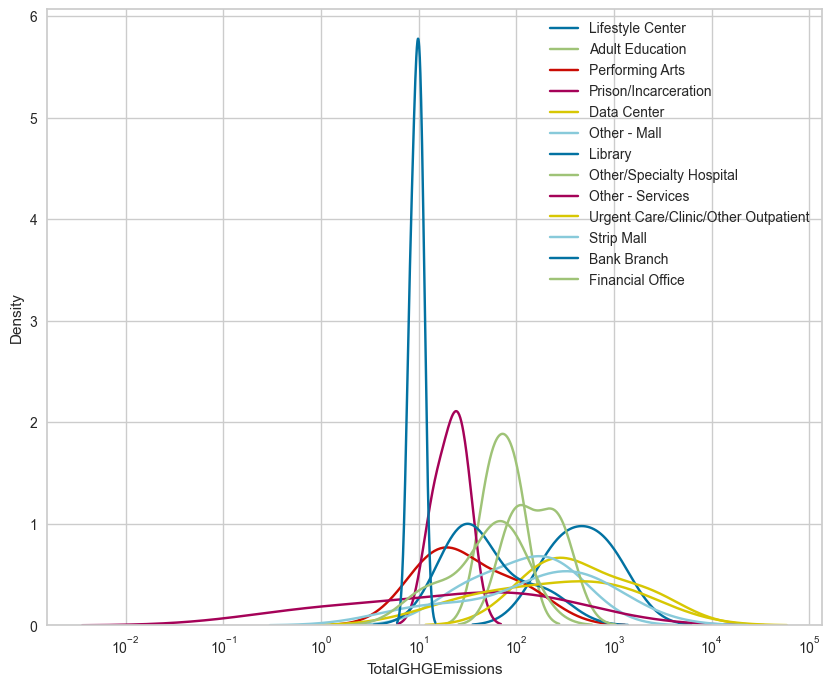

In [194]:
for cat in list_2_3_4_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][co2], label=cat, log_scale=True)
plt.legend();

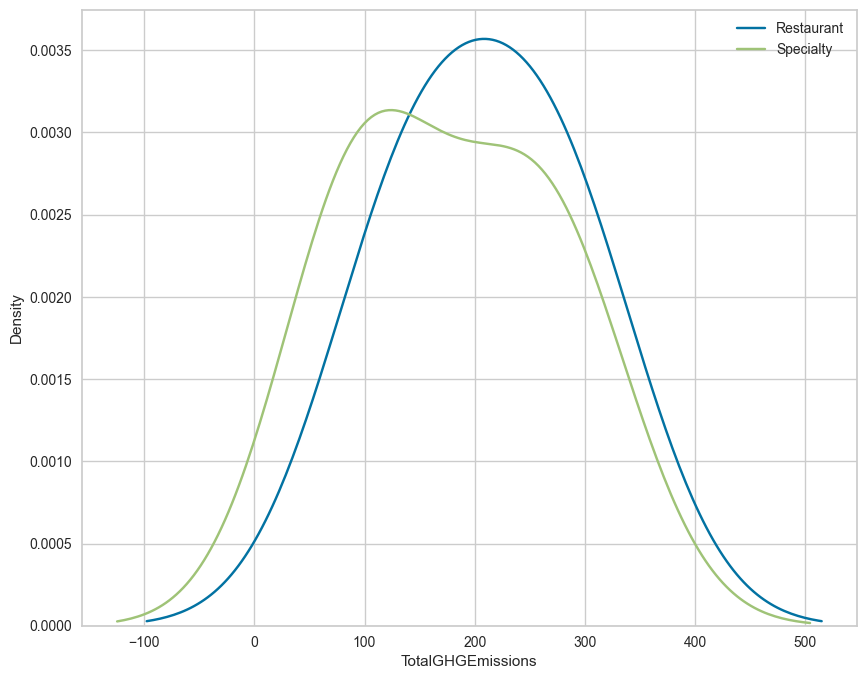

In [188]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Restaurant/Bar'][co2], label='Restaurant')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other/Specialty Hospital'][co2], label='Specialty')
plt.legend();

In [190]:
dict_replace.clear()
dict_replace[0] = {'Other - Restaurant/Bar':'grp_1', 'Other/Specialty Hospital':'grp_1'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_std))

Regroupement de Other - Restaurant/Bar, Other/Specialty Hospital


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.53  1562.99  37.47   -0.01  0.26    0.57  0.13
XGBoost            14.1   1855.6   40.1   -0.02  0.27    0.26  0.12

In [191]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

> Nous n'améliorons pas le score **RMSE** grâce à ce regroupement.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 5 observations:

In [ ]:
list_2_to_5_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==3].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==4].index)+ list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==5].index)

In [ ]:
for cat in list_2_to_5_cat:
    sns.swarmplot(x=list_2_to_5_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][co2])

plt.xticks(ticks=[list_2_to_5_cat.index(cat) for cat in list_2_to_5_cat], labels=list_2_to_5_cat)
plt.xticks(rotation=90);
plt.yscale('log')

In [ ]:
for cat in list_2_to_5_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][co2], label=cat, log_scale=True)
plt.legend();

In [ ]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Lodging/Residential'][co2], label='Lodging')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Automobile Dealership'][co2], label='Automobile')
plt.legend();

In [ ]:
dict_replace.clear()
dict_replace[0] = {'Other - Lodging/Residential':'grp_4', 'Automobile Dealership':'grp_4'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_std))

In [ ]:
best_rmse[-1]

> Ce regroupement ne permet pas d'améliorer le score **RMSE**.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 9 observations:

In [195]:
list_2_to_9_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==3].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==4].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==5].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==6].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==7].index)+list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==8].index)+list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==9].index)
list_2_to_9_cat.remove("Other - Utility")
list_2_to_9_cat.remove("Other - Restaurant/Bar")
list_2_to_9_cat.remove("Other - Public Services")

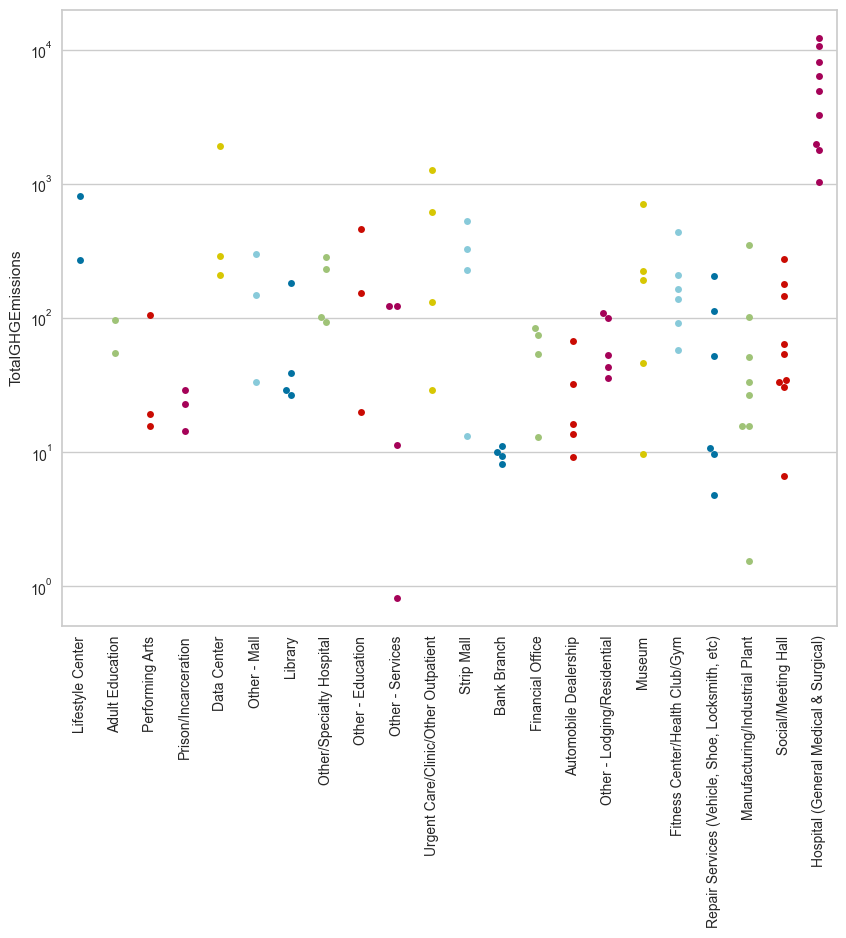

In [196]:
for cat in list_2_to_9_cat:
    sns.swarmplot(x=list_2_to_9_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][co2])

plt.xticks(ticks=[list_2_to_9_cat.index(cat) for cat in list_2_to_9_cat], labels=list_2_to_9_cat)
plt.xticks(rotation=90)
plt.yscale('log')

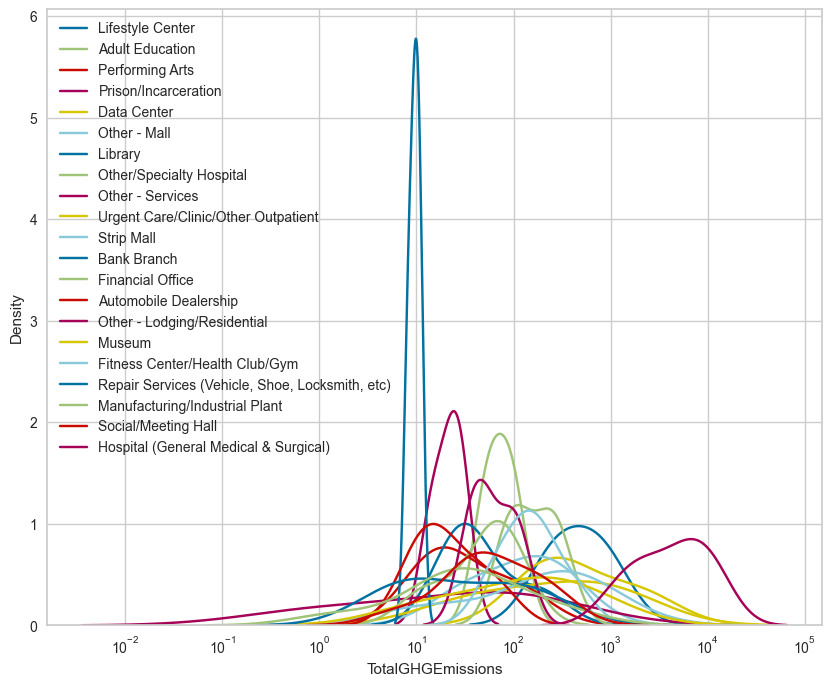

In [197]:
for cat in list_2_to_9_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][co2], label=cat, log_scale=True)
plt.legend();

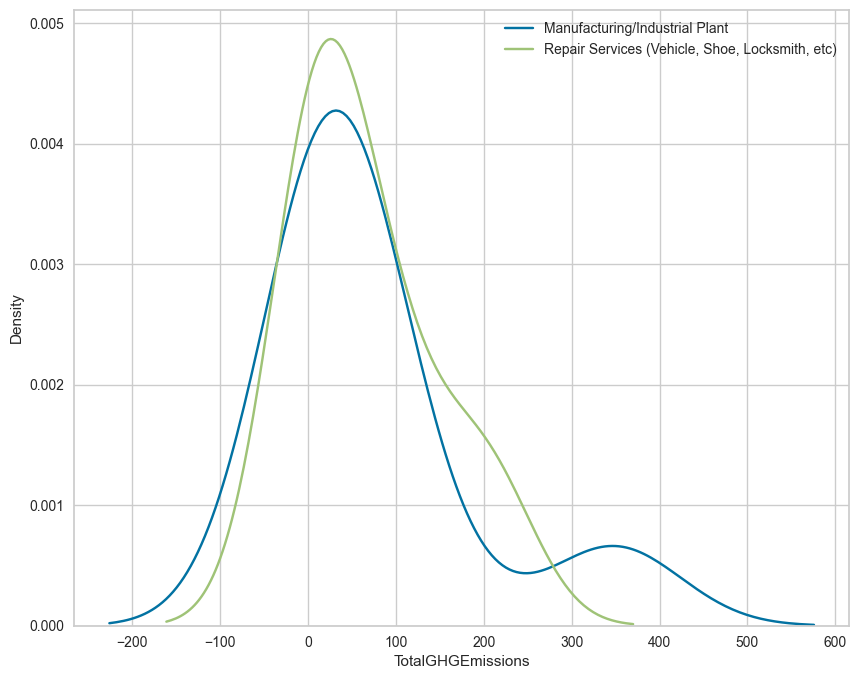

In [202]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Manufacturing/Industrial Plant'][co2], label='Manufacturing/Industrial Plant')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Repair Services (Vehicle, Shoe, Locksmith, etc)'][co2], label='Repair Services (Vehicle, Shoe, Locksmith, etc)')
plt.legend();

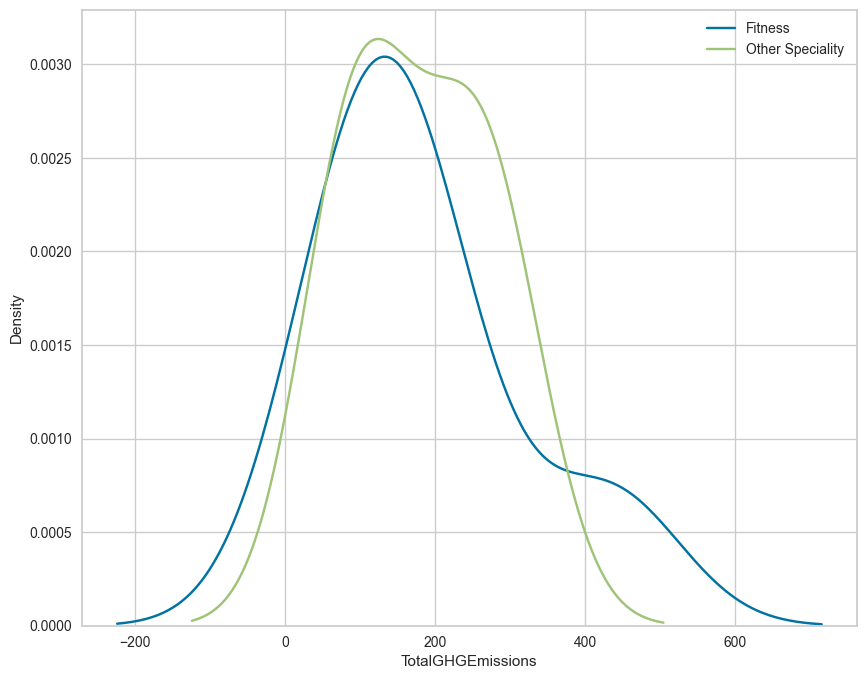

In [204]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Fitness Center/Health Club/Gym'][co2], label='Fitness')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other/Specialty Hospital'][co2], label='Other Speciality')
plt.legend();

In [203]:
dict_replace.clear()
dict_replace[0] = {'Manufacturing/Industrial Plant':'grp_2', 'Repair Services (Vehicle, Shoe, Locksmith, etc)':'grp_2'}
dict_replace[1] = {'Fitness Center/Health Club/Gym':'grp_3', 'Other/Specialty Hospital':'grp_3'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_std))

Regroupement de Manufacturing/Industrial Plant, Repair Services (Vehicle, Shoe, Locksmith, etc)


MAE     MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                             
GradientBoosting  13.49  1649.0  37.81   -0.14  0.26    0.58  0.02
XGBoost           14.15  1852.8  40.05   -0.01  0.27     0.3  0.13

Regroupement de Fitness Center/Health Club/Gym, Other/Specialty Hospital


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.66  1637.72  38.14   -0.03  0.27    0.56  0.11
XGBoost           14.28  1874.52  40.26   -0.01  0.27    0.26  0.13

In [205]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

> Aucun des regroupements précédents ne permet d'améliorer significativement le score **RMSE**.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 16 observations:

In [212]:
list_2_to_16_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index)
for i in range(3,17):
    list_2_to_16_cat += list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==i].index)
    
list_2_to_16_cat.remove("Other - Utility")
list_2_to_16_cat.remove("Other - Restaurant/Bar")
list_2_to_16_cat.remove("Other - Public Services")
list_2_to_16_cat.remove("Lifestyle Center")
list_2_to_16_cat.remove("Bank Branch")

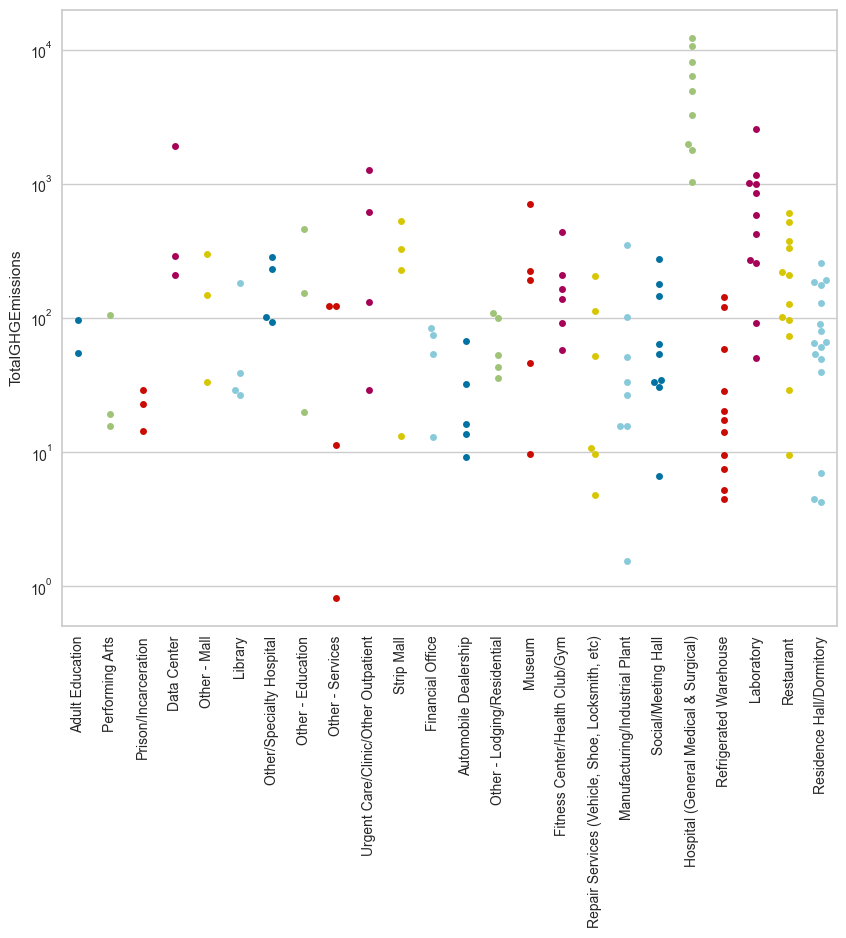

In [213]:
for cat in list_2_to_16_cat:
    sns.swarmplot(x=list_2_to_16_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][co2])

plt.xticks(ticks=[list_2_to_16_cat.index(cat) for cat in list_2_to_16_cat], labels=list_2_to_16_cat)
plt.xticks(rotation=90)
plt.yscale('log')

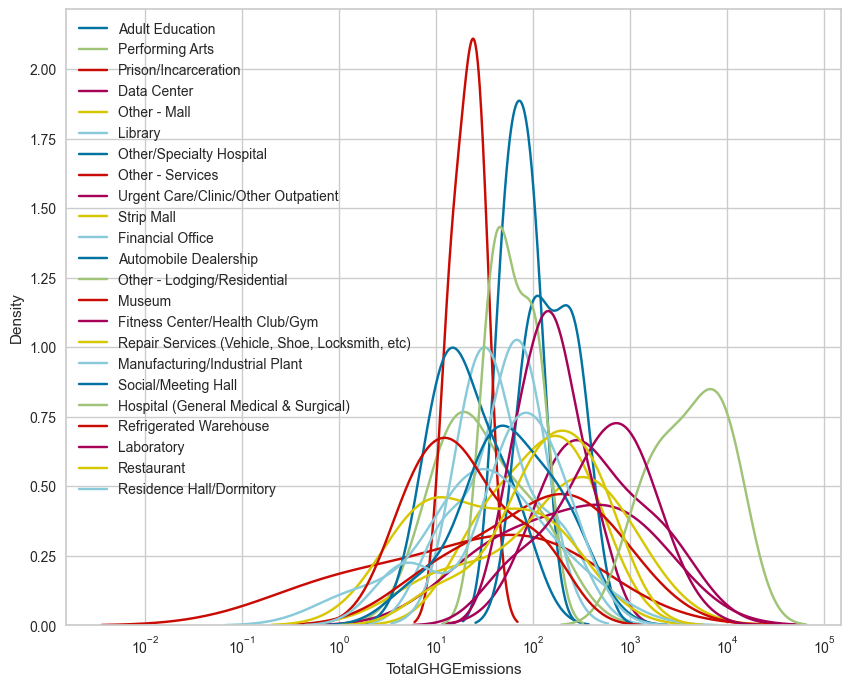

In [214]:
for cat in list_2_to_16_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][co2], label=cat, log_scale=True)
plt.legend();

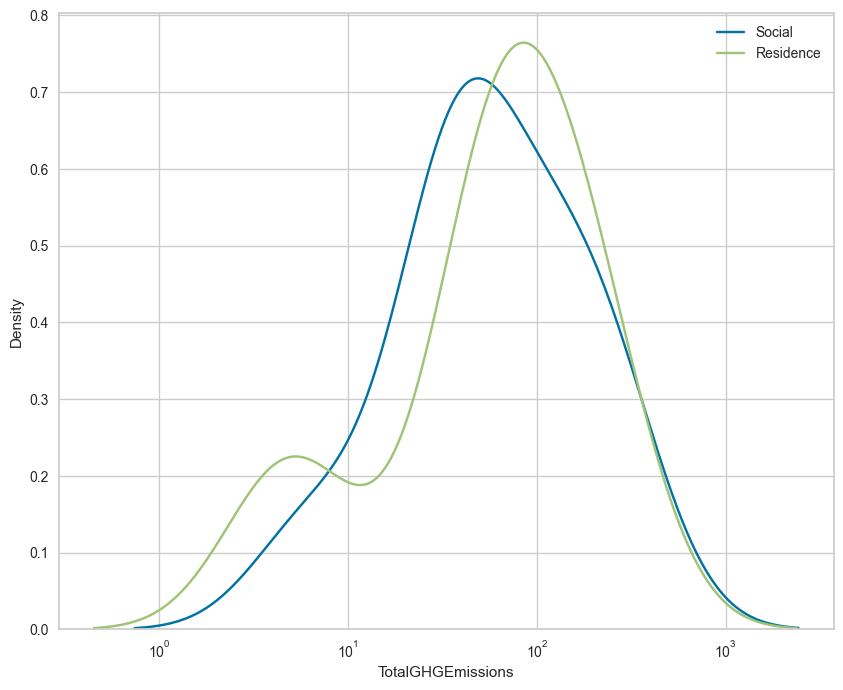

In [218]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Social/Meeting Hall'][co2], label='Social', log_scale=True)
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Residence Hall/Dormitory'][co2], label='Residence', log_scale=True)
plt.legend();

In [219]:
dict_replace.clear()
dict_replace[0] = {'Social/Meeting Hall':'grp_2', 'Residence Hall/Dormitory':'grp_2'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_std))

Regroupement de Social/Meeting Hall, Residence Hall/Dormitory


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.48  1438.83  36.17    0.01  0.27    0.58  0.14
XGBoost            14.2  1853.61  40.05   -0.01  0.27    0.26  0.13

In [220]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

> Aucun des regroupements ne permet d'améliorer significativement le score **RMSE**

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 4 à 26 observations:

In [221]:
list_4_to_26_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index)
for i in range(4,41):
    list_4_to_26_cat += list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==i].index)
list_4_to_26_cat.remove("Other - Utility")
list_4_to_26_cat.remove("Other - Restaurant/Bar")
list_4_to_26_cat.remove("Other - Public Services")
list_4_to_26_cat.remove("Lifestyle Center")
list_4_to_26_cat.remove("Bank Branch")

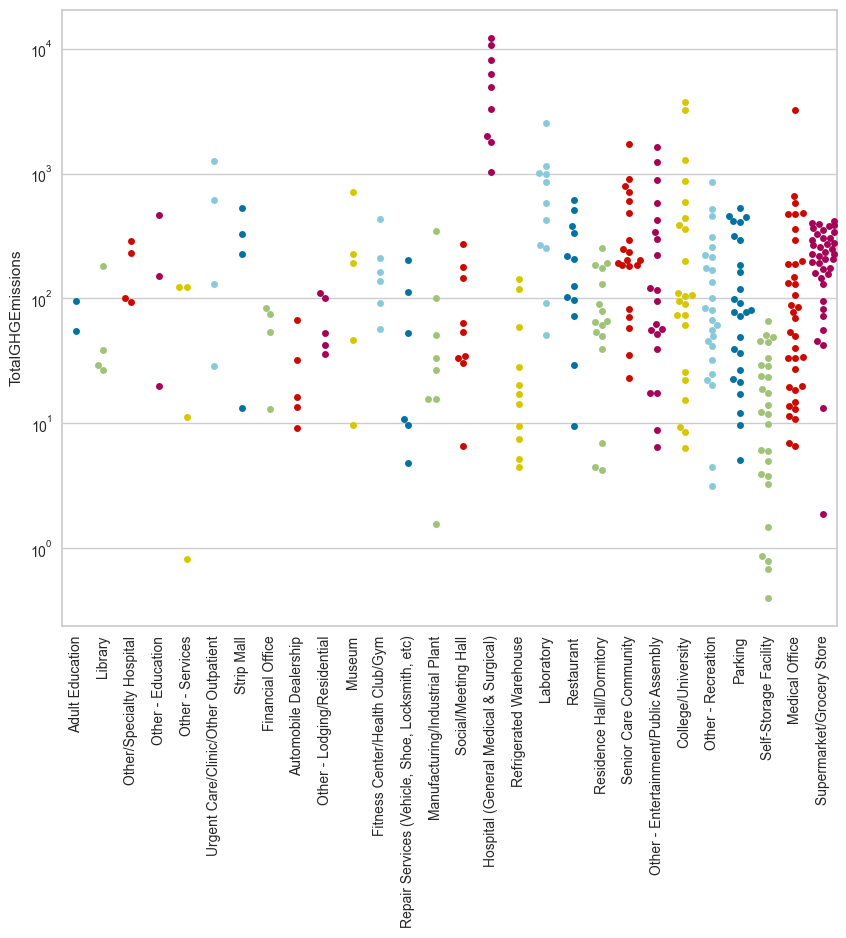

In [222]:
for cat in list_4_to_26_cat:
    sns.swarmplot(x=list_4_to_26_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][co2])

plt.xticks(ticks=[list_4_to_26_cat.index(cat) for cat in list_4_to_26_cat], labels=list_4_to_26_cat)
plt.xticks(rotation=90)
plt.yscale('log')

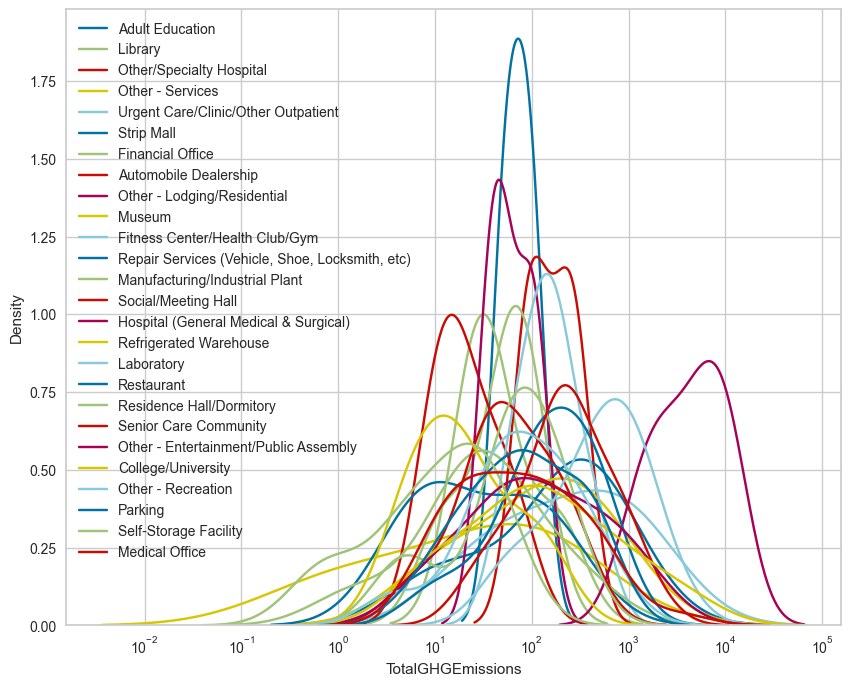

In [223]:
for cat in list_4_to_26_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][co2], label=cat, log_scale=True)
plt.legend();

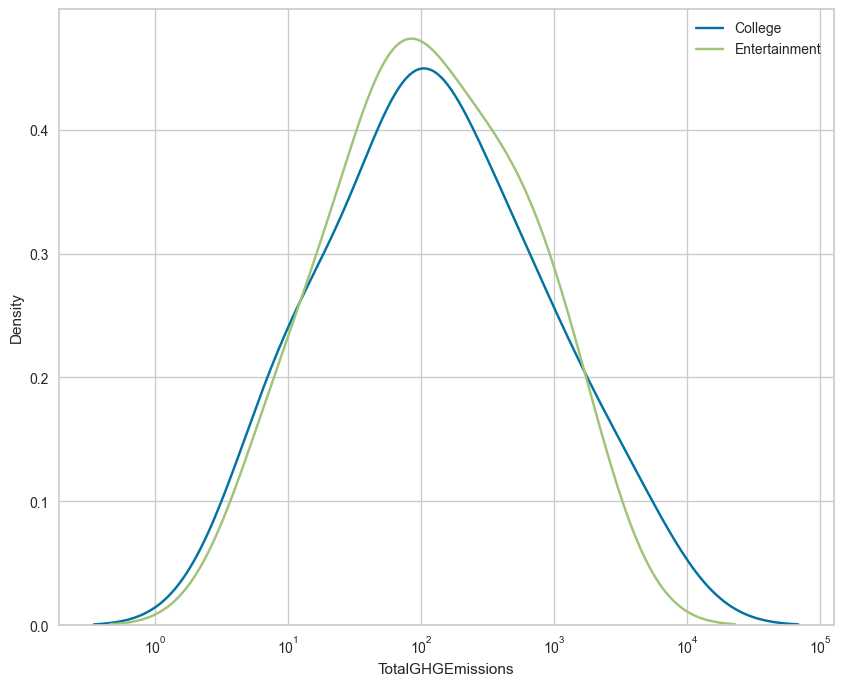

In [224]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'College/University'][co2], label='College', log_scale=True)
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Entertainment/Public Assembly'][co2], label='Entertainment', log_scale=True)
plt.legend();

In [225]:
dict_replace.clear()
dict_replace[0] = {'College/University':'grp_2', 'Other - Entertainment/Public Assembly':'grp_2'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_std))

Regroupement de College/University, Other - Entertainment/Public Assembly


MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.54  1617.86  37.88   -0.07  0.27    0.54  0.08
XGBoost           14.19  1865.65  40.06    0.02  0.27    0.25  0.15

In [226]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

> Ce regroupement ne permet pas d'améliorer significativement le score **RMSE**.

Tout notre travail sur le regroupement de modalités au sein des variables catégorielles jusqu'à présent nous a permis d'améliorer notre score **RMSE**.

Cependant, les 2 variables **PrimaryPropertyType** et **LargestPropertyType** reflètant la même chose, la diversité des types d'usage des bâtiments, mais avec une granularité différente, nous pouvons donc légitimement nous demander si l'une ou l'autre apporte une information redondante et si nous obtiendrions de meilleurs résultats sans l'une des 2.

C'est ce que nous allons vérifier :

In [227]:
X_train_tr_qt_log_wo_x1 = df_train_qt_log.drop(columns=dict_cols_grps['PrimaryPropertyType']).to_numpy()
X_train_tr_qt_log_wo_x2 = df_train_qt_log.drop(columns=dict_cols_grps['LargestPropertyUseType']).to_numpy()

In [228]:
cross_val_promising_models(X_train_tr_qt_log_wo_x1, y_train_tr_std)

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.65  1635.35   37.7   -0.17  0.27    0.49 -0.03
XGBoost           14.17  1835.76  39.93    0.02  0.27    0.23  0.14

In [229]:
cross_val_promising_models(X_train_tr_qt_log_wo_x2, y_train_tr_std)

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.75  1675.08  38.26   -0.12  0.27    0.44 -0.01
XGBoost           14.63  1972.26  41.29   -0.05  0.28    0.25  0.06

In [230]:
best_rmse[-1]

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  13.51  1423.19  36.08     0.0  0.27    0.55  0.14
XGBoost           14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

Nous n'obtenons pas un meilleur score **RMSE** sans l'une ou l'autre de ces 2 variables, mais est-ce le cas si nous retirons certaines de nos autres variables du jeu de données : 

In [237]:
def cross_val(X_train, y_train, model):
    
    name_mdl = model
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[name_mdl]
                     )
        
    dict_results ={
                    'MAE':[],
                    'MSE':[], 
                    'RMSE':[],
                    'adj. R²':[],
                    'R²':[],
                    'RMSLE':[],
                    'TT(sec)':[]
            }

    for train_index, test_index in kfold.split(X):
        mdl = clone(promising_models_to_train[name_mdl])

        start_fit_time = timeit.default_timer()
        mdl.fit(X[train_index], y[train_index])
        fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
        dict_results['TT(sec)'].append(fit_duration)

        y_pred_qt = mdl.predict(X[test_index])

        for mtr_name, metric in metrics.items():
            score = metric(y_true=np.abs(target_prepro_std.inverse_transform(y))[test_index], 
                           y_pred=np.abs(target_prepro_std.inverse_transform(y_pred_qt.reshape(-1,1))))
            if mtr_name in ('RMSE','RMSLE'):
                score = np.sqrt(score)
            elif mtr_name == 'adj. R²':
                score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
            dict_results[mtr_name].append(score)

    for mtr_name, scores in dict_results.items():            
        df.loc[name_mdl, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

In [233]:
best_rmse[0]

MAE      MSE  RMSE adj. R² RMSLE TT(sec)    R²
Model                                                             
XGBoost           14.09  1876.95  40.2    0.13  0.27    0.26  0.15
GradientBoosting  13.52  1578.26  37.6    0.15  0.27    0.57  0.16

In [234]:
min_to_beat_xgb = 40.2 # meilleur score RMSE obtenu suite au pré-traitement des variables numérique
dict_rmse_drop_xgb_0 = dict()

for key, value in dict_cols_grps.items():
    X_drop = df_train_qt_log.drop(columns=value).to_numpy()
    new_rmse = cross_val(X_drop, y_train_tr_std, 'XGBoost')['RMSE'][0]
    if new_rmse < min_to_beat_xgb:
        dict_rmse_drop_xgb_0[key] = new_rmse
        
dict_rmse_drop_xgb_0

{}

In [238]:
min_to_beat_gbr = 37.6 # meilleur score RMSE obtenu suite au pré-traitement des variables numérique
dict_rmse_drop_gbr_0 = dict()

for key, value in dict_cols_grps.items():
    X_drop = df_train_qt_log.drop(columns=value).to_numpy()
    new_rmse = cross_val(X_drop, y_train_tr_std, 'GradientBoosting')['RMSE'][0]
    if new_rmse < min_to_beat_gbr:
        dict_rmse_drop_gbr_0[key] = new_rmse
        
dict_rmse_drop_gbr_0

{'LargestPropertyUseTypeGFA': 36.5,
 'Longitude': 36.54,
 'NumberofBuildings': 36.42,
 'NumberofFloors': 36.23,
 'PropertyGFABuilding(s)': 36.42,
 'PropertyGFAParking': 36.44,
 'PropertyGFATotal': 36.58,
 'ThirdLargestPropertyUseTypeGFA': 35.15,
 'YearBuilt': 34.34,
 'SecondLargestPropertyUseType': 35.67}

In [240]:
dict_rmse_drop_gbr_1 = dict()

for key_0, value in dict_rmse_drop_gbr_0.items():
    dict_rmse_drop_gbr_1[key_0] = dict()
    dict_tmp = dict_cols_grps.copy()
    df_tmp = df_train_qt_log.drop(columns=dict_tmp[key_0])
    del dict_tmp[key_0]
    
    for key_1 in dict_tmp.keys():
        X_drop = df_tmp.drop(columns=dict_tmp[key_1]).to_numpy()
        new_rmse = cross_val(X_drop, y_train_tr_std, 'GradientBoosting')['RMSE'][0]
        if new_rmse < value:
            dict_rmse_drop_gbr_1[key_0][key_1] = new_rmse

dict_rmse_drop_gbr_1

{'LargestPropertyUseTypeGFA': {'Longitude': 36.26,
  'NumberofBuildings': 36.04,
  'NumberofFloors': 35.67,
  'SecondLargestPropertyUseTypeGFA': 36.49},
 'Longitude': {'LargestPropertyUseTypeGFA': 36.26,
  'SecondLargestPropertyUseTypeGFA': 36.37,
  'YearBuilt': 36.38},
 'NumberofBuildings': {'LargestPropertyUseTypeGFA': 36.04,
  'SecondLargestPropertyUseTypeGFA': 36.24},
 'NumberofFloors': {'LargestPropertyUseTypeGFA': 35.67,
  'PropertyGFABuilding(s)': 36.15,
  'PropertyGFATotal': 34.99,
  'SecondLargestPropertyUseTypeGFA': 35.16,
  'PrimaryPropertyType': 34.78,
  'ThirdLargestPropertyUseType': 35.21},
 'PropertyGFABuilding(s)': {'NumberofFloors': 36.15,
  'PropertyGFATotal': 36.22},
 'PropertyGFAParking': {'SecondLargestPropertyUseType': 35.79,
  'ThirdLargestPropertyUseType': 36.23},
 'PropertyGFATotal': {'NumberofBuildings': 36.56,
  'NumberofFloors': 34.99,
  'PropertyGFABuilding(s)': 36.22,
  'SecondLargestPropertyUseType': 35.52,
  'ThirdLargestPropertyUseType': 35.22},
 'Third

In [241]:
dict_rmse_drop_gbr = dict()
dict_rmse_drop_gbr[1] = dict_rmse_drop_gbr_0
dict_rmse_drop_gbr

{1: {'LargestPropertyUseTypeGFA': 36.5,
  'Longitude': 36.54,
  'NumberofBuildings': 36.42,
  'NumberofFloors': 36.23,
  'PropertyGFABuilding(s)': 36.42,
  'PropertyGFAParking': 36.44,
  'PropertyGFATotal': 36.58,
  'ThirdLargestPropertyUseTypeGFA': 35.15,
  'YearBuilt': 34.34,
  'SecondLargestPropertyUseType': 35.67}}

In [242]:
dict_rmse_drop_gbr[2] = dict()
for k0, value in dict_rmse_drop_gbr_1.items():
    for k1, rmse in value.items():
        dict_rmse_drop_gbr[2][k0,k1]=rmse
dict_rmse_drop_gbr[2]

{('LargestPropertyUseTypeGFA', 'Longitude'): 36.26,
 ('LargestPropertyUseTypeGFA', 'NumberofBuildings'): 36.04,
 ('LargestPropertyUseTypeGFA', 'NumberofFloors'): 35.67,
 ('LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA'): 36.49,
 ('Longitude', 'LargestPropertyUseTypeGFA'): 36.26,
 ('Longitude', 'SecondLargestPropertyUseTypeGFA'): 36.37,
 ('Longitude', 'YearBuilt'): 36.38,
 ('NumberofBuildings', 'LargestPropertyUseTypeGFA'): 36.04,
 ('NumberofBuildings', 'SecondLargestPropertyUseTypeGFA'): 36.24,
 ('NumberofFloors', 'LargestPropertyUseTypeGFA'): 35.67,
 ('NumberofFloors', 'PropertyGFABuilding(s)'): 36.15,
 ('NumberofFloors', 'PropertyGFATotal'): 34.99,
 ('NumberofFloors', 'SecondLargestPropertyUseTypeGFA'): 35.16,
 ('NumberofFloors', 'PrimaryPropertyType'): 34.78,
 ('NumberofFloors', 'ThirdLargestPropertyUseType'): 35.21,
 ('PropertyGFABuilding(s)', 'NumberofFloors'): 36.15,
 ('PropertyGFABuilding(s)', 'PropertyGFATotal'): 36.22,
 ('PropertyGFAParking', 'SecondLargestPrope

In [248]:
i=3
while True:
    dict_rmse_drop_gbr[i] = dict()

    for feats_to_drop, rmse in dict_rmse_drop_gbr[i-1].items():

        list_to_drop = list(feats_to_drop)
        dict_tmp = dict_cols_grps.copy()

        for feat_to_drop in list_to_drop:
            df_tmp = df_train_qt_log.drop(columns=dict_tmp[feat_to_drop])
            del dict_tmp[feat_to_drop]

        for feature in dict_tmp.keys():
            X_drop = df_tmp.drop(columns=dict_tmp[feature]).to_numpy()
            new_rmse = cross_val(X_drop, y_train_tr_std, 'GradientBoosting')['RMSE'][0]
            if new_rmse < rmse:
                new_fts_to_drop = list_to_drop.copy()
                new_fts_to_drop.append(feature)
                new_fts_to_drop = tuple(new_fts_to_drop)
                dict_rmse_drop_gbr[i][new_fts_to_drop] = new_rmse
                
    if len(dict_rmse_drop_gbr[i])==0:
        break
    else:
        print(f"Élimination de {i} variables:\n")
        display(dict_rmse_drop_gbr[i])
        i += 1

Élimination de 4 variables:



{('LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType'): 34.63,
 ('LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PropertyGFATotal'): 34.99,
 ('LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType'): 34.78,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PropertyGFATotal'): 34.99,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'SecondLargestPropertyUseTypeGFA'): 35.16,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType'): 34.78,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'ThirdLargestPropertyUseType'): 35.21,
 ('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofBuildings',
  'LargestPropertyUseTypeGFA'): 36.04,
 ('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PropertyGFATotal'): 34.99,
 ('Longitude',

Élimination de 5 variables:



{('LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 34.26,
 ('LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'YearBuilt'): 34.04,
 ('LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'LargestPropertyUseType'): 34.05,
 ('LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType'): 34.63,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType'): 34.63,
 ('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofBuildings',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors'): 35.67,
 ('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType'): 34.63,
 ('Lon

Élimination de 6 variables:



{('LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 34.26,
 ('LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'YearBuilt'): 34.04,
 ('LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'LargestPropertyUseType'): 34.05,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 34.26,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'YearBuilt'): 34.04,
 ('Longitude',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'LargestProp

Élimination de 7 variables:



{('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofBuildings',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType'): 34.63,
 ('Longitude',
  'YearBuilt',
  'ThirdLargestPropertyUseType',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 34.26,
 ('Longitude',
  'YearBuilt',
  'ThirdLargestPropertyUseType',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'LargestPropertyUseType'): 34.05,
 ('Longitude',
  'YearBuilt',
  'ThirdLargestPropertyUseType',
  'PropertyGFATotal',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType'): 34.63,
 ('PropertyGFABuilding(s)',
  'PropertyGFATotal',
  'ThirdLargestPropertyUseType',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 34.26,
 ('PropertyGFABuilding(s)',
  'PropertyGFATotal',
  'ThirdLargest

Élimination de 8 variables:



{('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofBuildings',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 34.26,
 ('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofBuildings',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'YearBuilt'): 34.04,
 ('Longitude',
  'SecondLargestPropertyUseTypeGFA',
  'NumberofBuildings',
  'LargestPropertyUseTypeGFA',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'LargestPropertyUseType'): 34.05,
 ('Longitude',
  'YearBuilt',
  'ThirdLargestPropertyUseType',
  'PropertyGFATotal',
  'NumberofFloors',
  'PrimaryPropertyType',
  'SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 34.26,
 ('Longitude',
  'YearBuilt',
  'ThirdLargestPropertyUseType',
  'PropertyGFATotal',
  'NumberofFloors',
  'PrimaryPropertyType',
  'S

En épurant les variables de notre jeu de données, pour le modèle **GradientBoosting**, nous passons d'un score **RMSE** de *37.6* à *34.04* soit **9.4%** d'amélioration, et ce qui est meilleur que le score obtenu suite à notre travail de feature engineering.

# Importance de la variable ENERGYSTARScore

Vérifions maintenant si l'ajout de la variable **ENERGYSTARScore** à notre jeu de données permet d'améliorer les résultats de nos modèles phares, puis nous reconduirons notre élagage de variables à partir de ce jeu de données augmenté :

In [249]:
df = data.copy()

In [250]:
co2 = 'TotalGHGEmissions'

cat_features = ['Neighborhood', 'PrimaryPropertyType',
                'LargestPropertyUseType',
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

num_features = ['LargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'NumberofBuildings', 
                     'NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
                     'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt', 'ENERGYSTARScore']

log_features = ['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 
                'ThirdLargestPropertyUseTypeGFA']

std_features = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
                'PropertyGFAParking', 'YearBuilt', 'ENERGYSTARScore']

In [251]:
df = df[num_features+cat_features+[co2]]

In [252]:
from sklearn.model_selection import train_test_split

X_train_star, _, y_train_star, _ = train_test_split(df.drop(columns=co2),df[co2], test_size=0.2, random_state=SEED)

X_train_star.reset_index(drop=True, inplace=True)
y_train_star.reset_index(drop=True, inplace=True)

In [253]:
cat_features_ind = [X_train_star.columns.get_loc(ft) for ft in cat_features]
numerical_features_ind = [X_train_star.columns.get_loc(ft) for ft in num_features]
log_features_ind = [X_train_star.columns.get_loc(ft) for ft in log_features]
qt_features_ind = [X_train_star.columns.get_loc(ft) for ft in std_features]

In [254]:
ft_prepro_qt_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                      ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), qt_features_ind),
                                      ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                     ])

In [255]:
X_train_star.dropna(inplace=True)
y_train_star = y_train_star[X_train_star.index]

In [256]:
X_train_star_tr_log_qt = ft_prepro_qt_log.fit_transform(X_train_star)
y_train_star_tr_qt = target_prepro_qt.transform(pd.DataFrame(y_train_star))

In [257]:
cross_val_promising_models(X_train_star_tr_log_qt, y_train_star_tr_qt)

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
Model                                                              
GradientBoosting  40.01   2806.3  52.67    0.52  0.97     0.3  0.59
XGBoost           42.24  3289.43  56.99    0.43  1.02    0.17  0.51

> Nous pouvons conclure ici que la variable **ENERGYSTAR** ne permet pas d'améliorer les performances de nos modèles.

Nous pouvons désormais considérer les jeu de données travaillés propres à nos modèles les plus prometteurs : **GradientBoosting** et **XGBoost**.

In [258]:
ft_to_drop_gradient = ['Longitude', 'SecondLargestPropertyUseTypeGFA', 'NumberofBuildings', 'LargestPropertyUseTypeGFA',
                       'NumberofFloors', 'PrimaryPropertyType', 'SecondLargestPropertyUseType', 'YearBuilt']

In [266]:
X_train_tr_qt_log_gradient = df_train_qt_log.copy()

for ft in ft_to_drop_gradient:
    X_train_tr_qt_log_gradient = X_train_tr_qt_log_gradient.drop(columns=dict_cols_grps[ft])
    
X_train_tr_qt_log_gradient = X_train_tr_qt_log_gradient.to_numpy()

X_train_tr_qt_log_xgb = df_ft_eng.to_numpy()

In [297]:
cross_val(X_train_tr_qt_log_gradient, y_train_tr_std, 'GradientBoosting')

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
GradientBoosting  12.74  1150.55  31.91    0.27  0.26    0.34  0.33

In [298]:
cross_val(X_train_tr_qt_log_xgb, y_train_tr_std, 'XGBoost')

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
XGBoost  14.24  1861.37  40.18   -0.01  0.27    0.31  0.13

Devant l'écrasante différence de performance entre nos 2 modèles prometteurs sur leur jeu de données optimal, nous décidons de n'ajuster les hyperparamètres que du modèle **GradientBoosting**.

# Ajustement des hyperparamètres

## Modèle GradientBoosting

In [269]:
from sklearn.model_selection import GridSearchCV

In [303]:
def cross_val_final(X_train, y_train, model, model_name):
    
    mdl = clone(model)
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model_name]
                     )
        
    dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }

    for train_index, test_index in kfold.split(X):
        
        start_fit_time = timeit.default_timer()
        mdl.fit(X[train_index], y[train_index])
        fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
        dict_results['TT(sec)'].append(fit_duration)

        y_pred_std = mdl.predict(X[test_index])

        for mtr_name, metric in metrics.items():
            score = metric(y_true=np.abs(target_prepro_std.inverse_transform(y))[test_index], 
                           y_pred=np.abs(target_prepro_std.inverse_transform(y_pred_std.reshape(-1,1))))
            if mtr_name in ('RMSE','RMSLE'):
                score = np.sqrt(score)
            elif mtr_name == 'adj. R²':
                score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
            dict_results[mtr_name].append(score)

    for mtr_name, scores in dict_results.items():            
        df.loc[model_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

In [271]:
df_gradient = data.copy()

In [272]:
co2 = 'TotalGHGEmissions'

cat_features_gradient = ['Neighborhood', 'PrimaryPropertyType',
                'LargestPropertyUseType',
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

num_features_gradient = ['LargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'NumberofBuildings', 
                     'NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
                     'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt']

log_features_gradient = ['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 
                'ThirdLargestPropertyUseTypeGFA']

qt_features_gradient = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
                'PropertyGFAParking', 'YearBuilt']

for liste in cat_features_gradient, num_features_gradient, log_features_gradient, qt_features_gradient:
    for feat in ft_to_drop_gradient:
        if feat in liste:
            liste.remove(feat)

In [274]:
df_gradient = df[cat_features_gradient+num_features_gradient+[co2]]

In [287]:
from sklearn.model_selection import train_test_split

X_train_gradient, X_test_gradient, y_train_gradient, y_test_gradient = train_test_split(df_gradient.drop(columns=co2),df_gradient[co2], test_size=0.2, random_state=SEED)

X_train_gradient.reset_index(drop=True, inplace=True)
X_test_gradient.reset_index(drop=True, inplace=True)
y_train_gradient.reset_index(drop=True, inplace=True)
y_test_gradient.reset_index(drop=True, inplace=True)

y_train_gradient_tr_std = target_prepro_std.transform(pd.DataFrame(y_train_gradient))

In [279]:
cat_features_gradient_ind = [X_train_gradient.columns.get_loc(ft) for ft in cat_features_gradient]
numerical_features_gradient_ind = [X_train_gradient.columns.get_loc(ft) for ft in num_features_gradient]
log_features_gradient_ind = [X_train_gradient.columns.get_loc(ft) for ft in log_features_gradient]
qt_features_gradient_ind = [X_train_gradient.columns.get_loc(ft) for ft in qt_features_gradient]

In [280]:
ft_prepro_qt_log_gradient = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_gradient_ind),
                                               ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), qt_features_gradient_ind),
                                               ('one_hot_cat_ft', cat_ft_pipeline, cat_features_gradient_ind)
                                              ])

X_train_gradient_tr_log_qt = ft_prepro_qt_log_gradient.fit_transform(X_train_gradient)

ohenc_col_names = ft_prepro_qt_log_gradient.named_transformers_['one_hot_cat_ft']['one_hot_cat_ft'].get_feature_names()
tr_col_names = list(num_features_gradient) + list(ohenc_col_names)

In [325]:
params_grid = {
    "learning_rate": np.arange(0.1,2,0.5),
    "subsample":np.arange(0.1,2,0.5),
}

gradient_search = GridSearchCV(gbr, params_grid, scoring='neg_root_mean_squared_error', cv=kfold)
gradient_search.fit(X_train_tr_qt_log_gradient, y_train_tr_std)

gradient_search.best_params_, gradient_search.best_score_, display(cross_val_final(X_train_tr_qt_log_gradient, y_train_tr_std, gradient_search.best_estimator_, 'GradientBoosting'))

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
GradientBoosting  13.85  1443.08  36.37    0.09  0.27    0.23  0.16

({'learning_rate': 0.1, 'subsample': 0.6}, -0.4795662074790551, None)

In [326]:
params_grid = {
    "n_estimators": range(100,2000,500),
    "min_samples_split": range(1,10,2),
    "learning_rate": np.arange(0.1,2,0.5),
    "subsample":np.arange(0.1,2,0.5),
}

gradient_search = GridSearchCV(gbr, params_grid, scoring='neg_root_mean_squared_error', cv=kfold)
gradient_search.fit(X_train_tr_qt_log_gradient, y_train_tr_std)

gradient_search.best_params_, gradient_search.best_score_, display(cross_val_final(X_train_tr_qt_log_gradient, y_train_tr_std, gradient_search.best_estimator_, 'gradient'))

MAE      MSE   RMSE adj. R² RMSLE TT(sec)    R²
gradient  14.26  1595.97  38.18   -0.01   0.3     1.4  0.07

({'learning_rate': 0.1,
  'min_samples_split': 3,
  'n_estimators': 600,
  'subsample': 0.6},
 -0.5033935876005177,
 None)

In [327]:
best_gradient = GradientBoostingRegressor(**{'learning_rate': 0.1, 'subsample': 0.6})

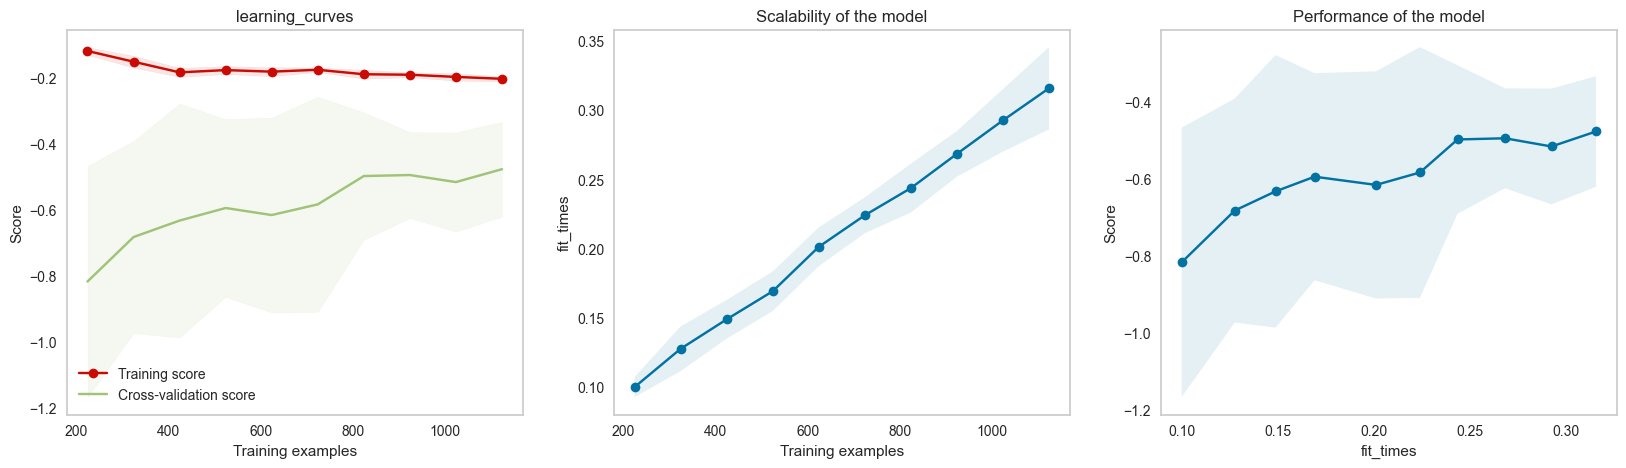

In [328]:
plot_learning_curve(
        best_gradient,
        "learning_curves",
        X_train_tr_qt_log_gradient, 
        y_train_tr_std,
        #axes=axes[:,i],
        cv=kfold,
        n_jobs=4,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.2, 1.0, 10)
    );
save_fig("Courbes d'apprentissage du meilleur modèle GradientBoosting")

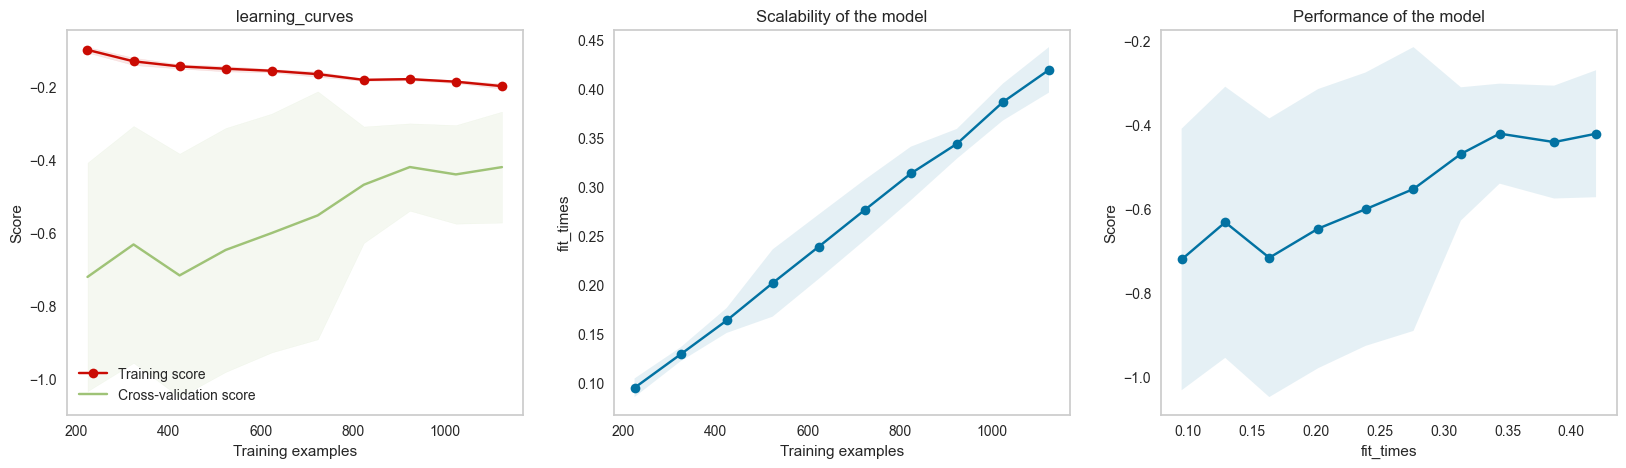

In [332]:
plot_learning_curve(
        gbr,
        "learning_curves",
        X_train_tr_qt_log_gradient, 
        y_train_tr_std,
        #axes=axes[:,i],
        cv=kfold,
        n_jobs=4,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.2, 1.0, 10)
    );
save_fig("Courbes d'apprentissage du modèle GradientBoosting par défaut")

Nous pouvons voir que l'ajustement des hyperparamètres nous a permis de réduire l'overfitting présent dans le modèle de base (nous pouvons voir que les courbes d'apprentissage sont plus proches pour le modèle ajusté), et également de réduire le **fit_times** du modèle avant atteinte du plateau de performance (le Score n'évolue plus).

Un moyen d'améliorer notre modèle serait d'augmenter le nombre d'observations d'entraînement, par exemple en prenant toutes les observations du jeu de données plutôt qu'en restreignant nos validations croisées au jeu d'entraînement suite au *train_test_split*.

# Importance des variables du meilleur modèle : GradientBoosting

In [330]:
from sklearn.pipeline import make_pipeline
best_gradient_pipe = make_pipeline(ft_prepro_qt_log_gradient, gbr)
best_gradient_pipe.fit(X_train_gradient, y_train_gradient_tr_std)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('log_num_ft',
                                                  FunctionTransformer(accept_sparse=False,
                                                                      check_inverse=True,
                                                                      func=<function log_tr at 0x000002005821D3A0>,
                                                                      inv_kw_args=None,
                                                                      inverse_func=None,
                                                                      kw_args=None,
                                                                      validate=False),
                                               

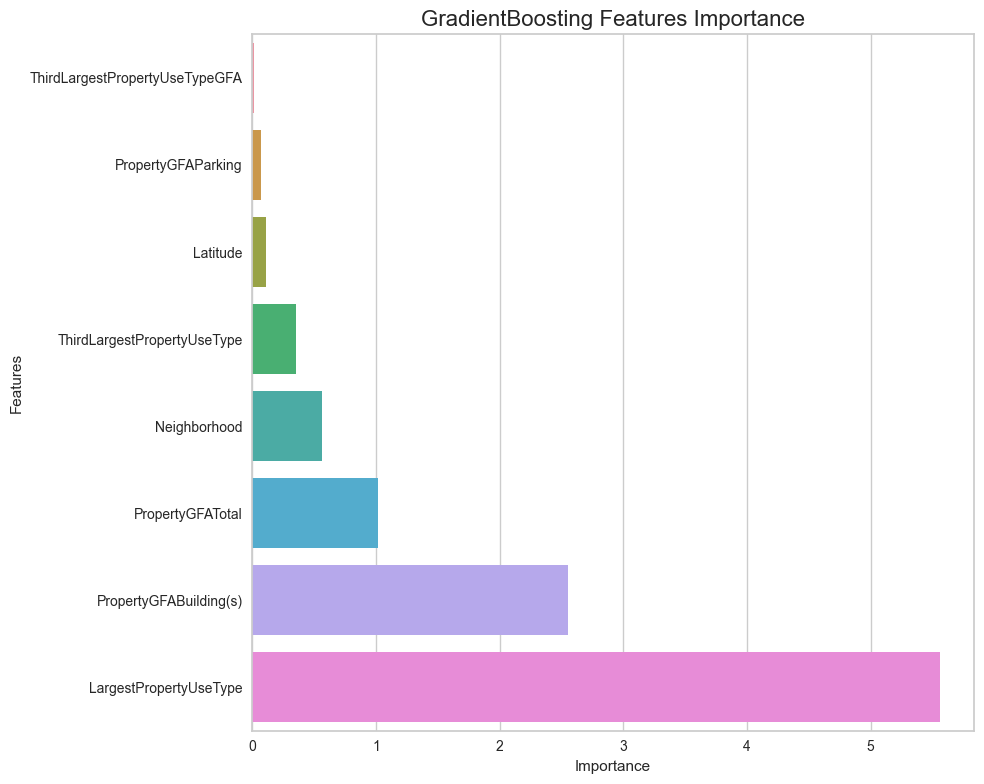

In [331]:
plot_features_importance(best_gradient_pipe, "GradientBoosting", X_train_gradient, y_train_gradient_tr_std, scoring='neg_root_mean_squared_error')

# Choix définitif du modèle

Le modèle nous ayant permis d'atteindre les meilleures performances dans notre objectif de prédiction des émissions de gaz à effet de serre des bâtiments de Seattle à partir de leurs variables structurelles est le modèle de régression **GradientBoosting**.

La variable **ENERGYSTARScore**, coûteuse à produire, ne permet pas d'améliorer les prédictions de notre variable cible et nous pourrons donc nous en passer pour les prochaines années.